In [800]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [801]:
from sympy import sqrt, cos, sin,  cosh,  sinh, Add
from sympy import Symbol, S, oo, Rational, Function, pi , factorial, O, symbols, lambdify, I
from sympy import Derivative, series, limit, Matrix, simplify, collect, solve, Poly, poly, diff, nsolve, transpose, factor_terms
from sympy import latex, init_printing
from sympy.core.numbers import NegativeOne, One, Zero
from sympy.printing.latex import print_latex

import numpy as np
from tqdm import tqdm
import ray
import time

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

from acchamiltoniansandmatrices.Tracking.LinearMatrixTracking import nestList, GenerateNDimCoordinateGrid
from acchamiltoniansandmatrices.Hamiltonians.LatticeElementHamiltonians import HamDrift6D, HamQuad6D
from acchamiltoniansandmatrices.Hamiltonians.Operators import Poisson
from acchamiltoniansandmatrices.LieMaps.Poisson import PoissonBracket
from acchamiltoniansandmatrices.LieMaps.LieOperator import LieOperator
from acchamiltoniansandmatrices.Utils.Plotting import multi_countour_plot
from acchamiltoniansandmatrices.Factorization.Factorization import truncate, taylorize, dragt_finn_factorization
from acchamiltoniansandmatrices.Utils.Polynomials import getpoly, RotationMatrix2D, explicitCheck, geteigenvects
from acchamiltoniansandmatrices.Matrices.NumpyMatrices import RnpQuad6DChroma
from acchamiltoniansandmatrices.Matrices.SymbMatrices import RsymbQuad6DChroma
from acchamiltoniansandmatrices.Integrators import integrator

# Initialization - run once

In [3]:
%matplotlib notebook
init_printing() 
ray.init()

2021-03-21 18:14:30,104	INFO services.py:1172 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.0.38',
 'raylet_ip_address': '192.168.0.38',
 'redis_address': '192.168.0.38:6379',
 'object_store_address': '/tmp/ray/session_2021-03-21_18-14-29_679812_16330/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-03-21_18-14-29_679812_16330/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-03-21_18-14-29_679812_16330',
 'metrics_export_port': 60753,
 'node_id': '3ad47164f7dc35273fdafdcb8328613b1d11ca47f57e0c26b785c970'}

# Symbolis and symbolic replacement lists

## Symbols

In [5]:
x, px, y, py, z, delta = symbols('x p_x y p_y z delta', real=True)
eps, h , k0, k1, k2, sigma, betag = symbols('epsilon h k_0 k_1 k_2 sigma beta_gamma', real=True)
L, beta0, gamma0 = symbols(" L beta_0 gamma_0", real=True, positive=True)
x0,px0 = symbols('x_0 px_0') # to not overwrite anything

# redefine for use in ringham - otherwise assumption errors
LQF   = symbols("L_{QF}")
LQD   = symbols("L_{QD}")
LD    = symbols("L_D")
LD2   = symbols("L_{D2}")
KQF   = symbols("K_{QF}")
KQD   = symbols("K_{QD}")
dld   = symbols('\delta{L_D}') # delta length drift

## Replacements

In [6]:
# standardized substitutions that are useful - ORDER IN LISTS COUNTS !!!!
betagamma_rep = list(zip([beta0 * gamma0, beta0],[oo,1]))
series_rep    = list(zip([px,py,delta],[eps*px,eps*py,eps*delta]))
coord_rep     = list(zip([x,y],[eps*x,eps*y]))
thin_rep      = list(zip([px,py,delta],[0,0,0]))
xpx_rep       = list(zip([y,py,delta],[0,0,0]))
eps_rep       = list(zip([x,y,z,px,py,delta],[eps*x,eps*y,0,px*eps,py*eps,0]))
xyplane_rep   = list(zip([y,py,z,delta],[0,0,0,0]))
track_rep     = list(zip([x,px],[x0,px0]))
inv_track_rep = list(zip([x0,px0],[x,px]))

# Island settings for tracking

## Setup 1

In [7]:
#Island setting
_ld1 = 2.55
_ld2 = 2.35 #2.48
_lqf = 0.3
_lqd = 0.804
_k1  = 0.7
_k2  = - 0.35

repj = list(zip([LD,LD2,LQF,LQD,KQF,KQD,dld],[_ld1,_ld2,_lqf,_lqd,_k1,_k2,0]))

## Setup 2

In [8]:
#Island setting
_ld1 = 3.5805
_ld2 = 3.5805
_lqf = 0.342
_lqd = 0.668
_k1  = 0.49
_k2  = - 0.4999

rept = list(zip([LD,LD2,LQF,LQD,KQF,KQD,dld],[_ld1,_ld2,_lqf,_lqd,_k1,_k2,0]))

# Beam line definition

In [9]:
eldict = { 'drift' : 1, 'quad'  : 2, 'squad' : 25, 'sext'  : 3}

beamlines = [
    [eldict['quad'] , 4, LQF, KQF, 0],
    [eldict['drift'], 4, LD , Zero(), 0   ],
    [eldict['quad'] , 4, LQD, KQD, 0],
    [eldict['drift'], 4, LD , Zero(), 0   ],
    [eldict['quad'] , 4, LQF, KQF, 0],
]

# Functions

In [10]:
def AssignHam(element, order=3, length=1, k=1,flag=1):
    '''
    Element:
    1 = drift space
    2 = quadrupole
    25 = skew quadrupole
    3 = sextupole
    35 = skew sextupole - tbp
    '''
    order = order +1
 
    if element == 1:
        # drift hamiltonian
        H = NegativeOne() * HamDrift6D(beta0, gamma0, length,x,px,y,py,delta)
        H = H.subs(betagamma_rep)
        H = H.subs(series_rep).series(eps,0,n=order).removeO()
        H = simplify(H.subs(eps,One()) - H.subs(eps,Zero()))

        
    elif element == 2:
        # quadrupole - thin is set by flag
        H = NegativeOne() * HamQuad6D(beta0,gamma0,length,x,px,y,py,delta,k)
        H = H.subs(betagamma_rep)
        H = H.subs(series_rep).series(eps,n=order).removeO()
        H = H.subs(coord_rep)
        H = simplify(H.subs(eps,One()) - H.subs(eps,Zero()))
        
        if flag:
            H = H.subs(thin_rep)
        
#         H = quad(order, length, strength, flag)
    elif element == 25:
        H = NegativeOne() *  HamSQuad6D(beta0,gamma0,length,x,px,y,py,delta,k)
        H = H.subs(betagamma_rep)
        H = H.subs(series_rep).series(eps,n=order).removeO()
        H = H.subs(coord_rep)
        H = simplify(H.subs(eps,One()) - H.subs(eps,Zero()))
        
        if flag:
            H = H.subs(thin_rep)
#         H = skew_quad(order, length, strength, flag)
        
    elif element == 3:
        H = NegativeOne() *  HamSext6D(beta0,gamma0,length,x,px,y,py,delta,k)
        H = H.subs(betagamma_rep)
        H = H.subs(series_rep).series(eps,n=order).removeO()
        H = H.subs(coord_rep)
        H = simplify(H.subs(eps,One()) - H.subs(eps,Zero()))
        
        if flag:
            H = H.subs(thin_rep)

    else:
        raise ValueError(element, ' no such reference in library.')      
    
    return H

In [11]:
def New_FIG(x,px,y,py,d2=False):
    fig = plt.figure(constrained_layout=True, figsize = (12,6))
    
    if d2:
        gs  = fig.add_gridspec(1, 2)
        ax1 = fig.add_subplot(gs[0,0])
        ax2 = fig.add_subplot(gs[0,1])
        ax2.set_xlabel('$y$')
        ax2.set_ylabel('$p_y$')
        ax2.plot(y,py,'k.',alpha=.1, label='Exact')
    else:
        gs  = fig.add_gridspec(1, 1)
        ax1 = fig.add_subplot(gs[0,0])

    ax1.set_xlabel('$x$')
    ax1.set_ylabel('$p_x$')
    ax1.plot(x,px,'k.',alpha=.1, label='Exact')

In [12]:
def truncatexpx(func, order):
    _e = symbols('epsilon')
    func = func.subs(x0,_e*x0).subs(px0,_e*px0)
    func = func + O(_e**(order+1))
    return func.removeO().subs(_e,1)

In [13]:
def eom(ham,q_symbols,p_symbols):
    dq_dt_expr = Matrix([diff(ham, pi).simplify() for pi in p_symbols])
    dp_dt_expr = Matrix([-diff(ham, qi).simplify() for qi in q_symbols])
    
    dq_dt_func = lambdify([q_symbols,p_symbols], dq_dt_expr)
    dp_dt_func = lambdify([q_symbols,p_symbols], dp_dt_expr)
    
    return dq_dt_func, dp_dt_func

# Init coordinates to track

In [14]:
dpx = 0.0 # to get into islands

R0 = GenerateNDimCoordinateGrid(6,2,man_ranges={
    0:[1.0000e-06, 1.0000e-04, 1.0000e-02, 1.0000e+00, 2.5000e-01,
       3.5000e-01, 4.5000e-01, 5.5000e-01, 6.5000e-01, 8.0000e-01,
       9.0000e-01, 1.0000e+00, 1.1000e+00, 1.2000e+00, 1.3000e+00,
       1.4000e+00, 1.5000e+00, 1.6000e+00, 1.7000e+00, 1.8000e+00,
       1.8500e+00, 1.9000e+00, 1.9500e+00, 2.0000e+00, 2.0125e+00,
       2.0250e+00, 2.0500e+00, 2.1000e+00, 2.2000e+00, 2.3000e+00],
    1:[0,dpx],
    2:[0],
    3:[0],
    4:[0],
    5:[0]
})
r0 = R0.T.reshape(int(R0.size/6),6)

Shape: (6, 2, 30, 1, 1, 1, 1) - Number of paritcles: 60 


# Tracking Function

In [15]:
def track(r, fx,fpx):
    _x = r[:,0]
    _px = r[:,1]
    _y = r[:,2]
    _py = r[:,3]
    _z = r[:,4]
    _pz = r[:,5]
    
    xn  = fx(_x,_px)
    pxn = fpx(_x,_px)
    
#     xn = xn + fpx(xn,_px)
#     pxn = pxn - fx(xn,_px)
    
    yn  = _y
    pyn = _py
    zn  = _z
    pzn = _pz
    
    return np.array([xn, pxn, yn, pyn, zn, pzn]).transpose()

# Element by Element Tracking

Here we track element by element using the individual Hamiltonians in the following way.
1. From the Hamiltonians the Taylor map to a given order is derived 
2. Taylor maps are applied sequentially in a symbolic way 
3. Final expression is an effective tracking map (non-symplectic)

## Assign Hamiltonians

In [802]:
HQF2 = AssignHam(*[eldict['quad'] , 4, LQF, KQF, 0])
HD_4 = AssignHam(*[eldict['drift'], 4, LD , Zero(), 0])
HQD2 = AssignHam(*[eldict['quad'] , 4, LQD, KQD, 0])

In [803]:
HQF2_op = LieOperator(HQF2.subs(xyplane_rep).expand().subs(rept),[x],[px])
HD_4_op = LieOperator(HD_4.subs(xyplane_rep).expand().subs(rept),[x],[px])
HQD2_op = LieOperator(HQD2.subs(xyplane_rep).expand().subs(rept),[x],[px])

## Build Taylor maps

In [804]:
taylor_qf2_x  =  HQF2_op.LieMap(x,2).ham
taylor_qf2_px =  HQF2_op.LieMap(px,2).ham

taylor_qf4_x  =  HQF2_op.LieMap(x,5).ham
taylor_qf4_px =  HQF2_op.LieMap(px,5).ham

taylor_d4_x   =  HD_4_op.LieMap(x,4).ham
taylor_d4_px  =  HD_4_op.LieMap(px,4).ham

taylor_qd2_x  =  HQD2_op.LieMap(x,2).ham
taylor_qd2_px =  HQD2_op.LieMap(px,2).ham

taylor_qd4_x  =  HQD2_op.LieMap(x,5).ham
taylor_qd4_px =  HQD2_op.LieMap(px,5).ham

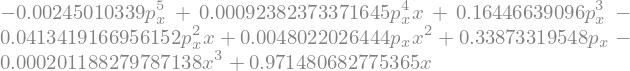

In [170]:
taylor_qf4_x

## Build effective Taylor

In [25]:
track_rep # used as dummies

In [368]:
print_latex(taylor_qf4_x)

3.15947716931026 \cdot 10^{-5} p_{x}^{7} - 0.00233074536360384 p_{x}^{5} + 0.00092382373371645 p_{x}^{4} x - 0.000144493422543123 p_{x}^{3} x^{2} + 0.164583408632937 p_{x}^{3} - 0.0413419166956152 p_{x}^{2} x + 0.00465082858268816 p_{x} x^{2} + 0.338742556893835 p_{x} - 0.000201188279787138 x^{3} + 0.971480682775365 x


In [172]:
truncate_bool  = True
truncate_order = 5
    

tic = time.perf_counter()
# QF
x1  = taylor_qf4_x.subs(track_rep).subs(rept).expand() 
px1 = taylor_qf4_px.subs(track_rep).subs(rept).expand()

if truncate_bool:
    x1 = truncatexpx(x1,truncate_order)
    px1 = truncatexpx(px1,truncate_order)

# QF - D
x2  = taylor_d4_x.subs(list(zip([x,px],[x1,px1]))).subs(rept).expand()
px2 = taylor_d4_px.subs(list(zip([x,px],[x1,px1]))).subs(rept).expand()

if truncate_bool:
    x2 = truncatexpx(x2,truncate_order)
    px2 = truncatexpx(px2,truncate_order)

# QF - D - QD 
x3  = taylor_qd4_x.subs(list(zip([x,px],[x2,px2]))).subs(rept).expand()
px3 = taylor_qd4_px.subs(list(zip([x,px],[x2,px2]))).subs(rept).expand()

if truncate_bool:
    x3 = truncatexpx(x3,truncate_order)
    px3 = truncatexpx(px3,truncate_order)

# QF - D - QD - D
x4  = taylor_d4_x.subs(list(zip([x,px],[x3,px3]))).subs(rept).expand()
px4 = taylor_d4_px.subs(list(zip([x,px],[x3,px3]))).subs(rept).expand()

if truncate_bool:
    x4 = truncatexpx(x4,truncate_order)
    px4 = truncatexpx(px4,truncate_order)

# QF - D - QD - D - QF
x5  = taylor_qf4_x.subs(list(zip([x,px],[x4,px4]))).subs(rept).expand()
px5 = taylor_qf4_px.subs(list(zip([x,px],[x4,px4]))).subs(rept).expand()

if truncate_bool:
    x5 = truncatexpx(x5,truncate_order)
    px5 = truncatexpx(px5,truncate_order)

print("took {}".format(time.perf_counter()-tic))

took 17.28286390300491


In [173]:
# generate tracking maps for non-symplectic taylor
tic = time.perf_counter()

x5expanded  =  x5.subs(inv_track_rep)
px5expanded = px5.subs(rept).subs(inv_track_rep).expand()

a = LieOperator(x5expanded,[x],[px])
b = LieOperator(px5expanded,[x],[px])

fxt2  = truncate(a,20)
fpxt2 = truncate(b,20)

ffxt2 = lambdify((x,px),fxt2)
ffpxt2 = lambdify((x,px),fpxt2)

print("took {}".format(time.perf_counter()-tic))

took 0.18303405899496283


## Build symplectic Taylor (order 1 symplectic integrator)

In [805]:
dqt1_expr = diff(HQF2.subs(xyplane_rep).expand().subs(rept),px)
dpt1_expr = -diff(HQF2.subs(xyplane_rep).expand().subs(rept),x) # minyus sign !!!

dqt2_expr = diff(HD_4.subs(xyplane_rep).expand().subs(rept),px)
dpt2_expr = -diff(HD_4.subs(xyplane_rep).expand().subs(rept),x) # minyus sign !!!

dqt3_expr = diff(HQD2.subs(xyplane_rep).expand().subs(rept),px)
dpt3_expr = -diff(HQD2.subs(xyplane_rep).expand().subs(rept),x) # minyus sign !!!

In [806]:
dqt1 = lambdify((x,px),dqt1_expr)
dpt1 = lambdify((x,px),dpt1_expr) # minyus sign !!!

dqt2 = lambdify((x,px),dqt2_expr)
dpt2 = lambdify((x,px),dpt2_expr) # minyus sign !!!

dqt3 = lambdify((x,px),dqt3_expr)
dpt3 = lambdify((x,px),dpt3_expr) # minyus sign !!!

In [807]:
xx1_expr = x  + dqt1_expr
px1_expr = px + dpt1_expr.subs(x,xx1_expr)

xx2_expr = xx1_expr  + dqt2_expr
px2_expr = px1_expr  + dpt2_expr.subs(x,xx2_expr)

xx3_expr = xx2_expr  + dqt3_expr
px3_expr = px2_expr  + dpt3_expr.subs(x,xx3_expr)

xx4_expr = xx3_expr  + dqt2_expr
px4_expr = px3_expr  + dpt2_expr.subs(x,xx4_expr)

xx5_expr = xx4_expr  + dqt1_expr
px5_expr = px4_expr  + dpt1_expr.subs(x,xx5_expr)

# xx5_expr, px5_expr

## Tracking

In [29]:
def track_symplectic(r):
    __x = r[:,0]
    _px = r[:,1]
    __y = r[:,2]
    _py = r[:,3]
    __z = r[:,4]
    _pz = r[:,5]
    
    xx1  = __x + dqt1(__x,_px)
    px_1 = _px + dpt1(xx1,_px)
    
    xx2  = xx1  + dqt2(xx1,px_1)
    px_2 = px_1 + dpt2(xx2,px_1)
    
    xx3  = xx2  + dqt3(xx2,px_2)
    px_3 = px_2 + dpt3(xx3,px_2)
    
    xx4  = xx3  + dqt2(xx3,px_3)
    px_4 = px_3 + dpt2(xx4,px_3)
    
    xx5  = xx4  + dqt1(xx4,px_4)
    px_5 = px_4 + dpt1(xx5,px_4)
    
    return np.array([xx5, px_5, __y, _py, __z, _pz]).transpose()

In [176]:
X_ElByEl_2_4_2 = np.array([r0])
X_ElByEl_2_4_2_symplectic = np.array([r0])

duration = 200

for i in tqdm(range(1, duration + 1)): 
    r_2      = track(X_ElByEl_2_4_2[-1],ffxt2,ffpxt2)
    r_2_symp = track_symplectic(X_ElByEl_2_4_2_symplectic[-1])
    
    X_ElByEl_2_4_2 = np.append(X_ElByEl_2_4_2, [r_2], axis = 0)
    X_ElByEl_2_4_2_symplectic= np.append(X_ElByEl_2_4_2_symplectic, [r_2_symp], axis = 0)

100%|██████████| 200/200 [00:00<00:00, 2304.30it/s]


<IPython.core.display.Javascript object>


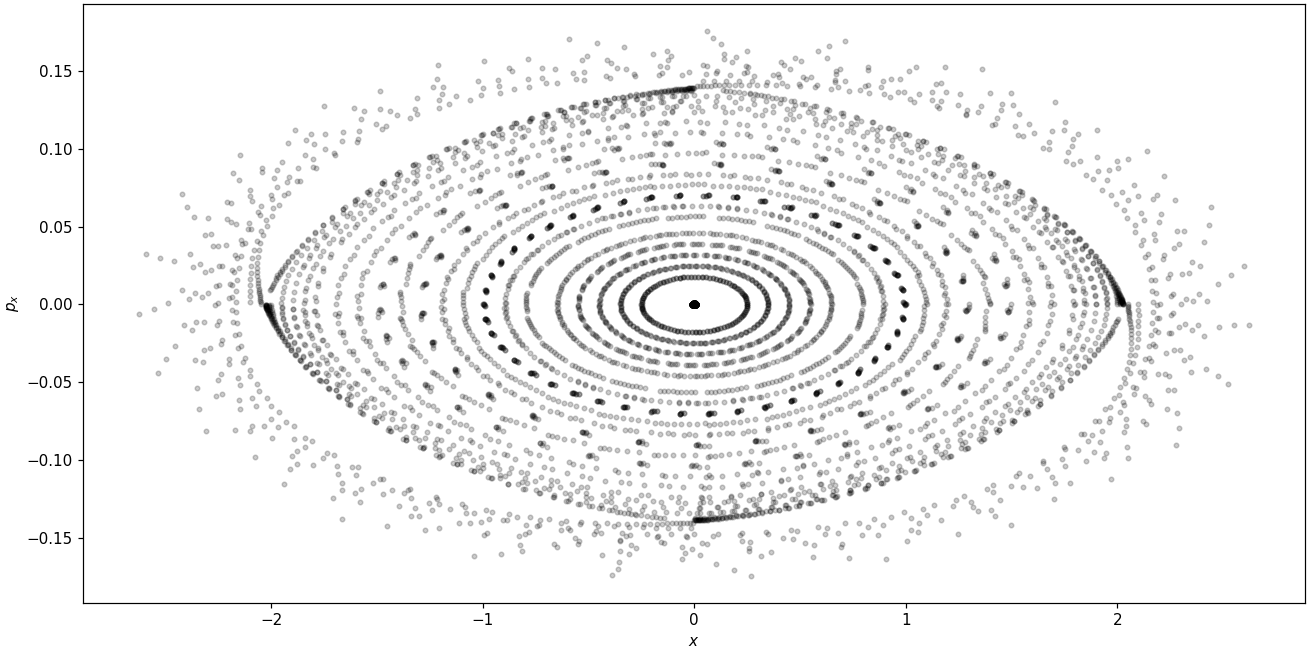

<IPython.core.display.Javascript object>


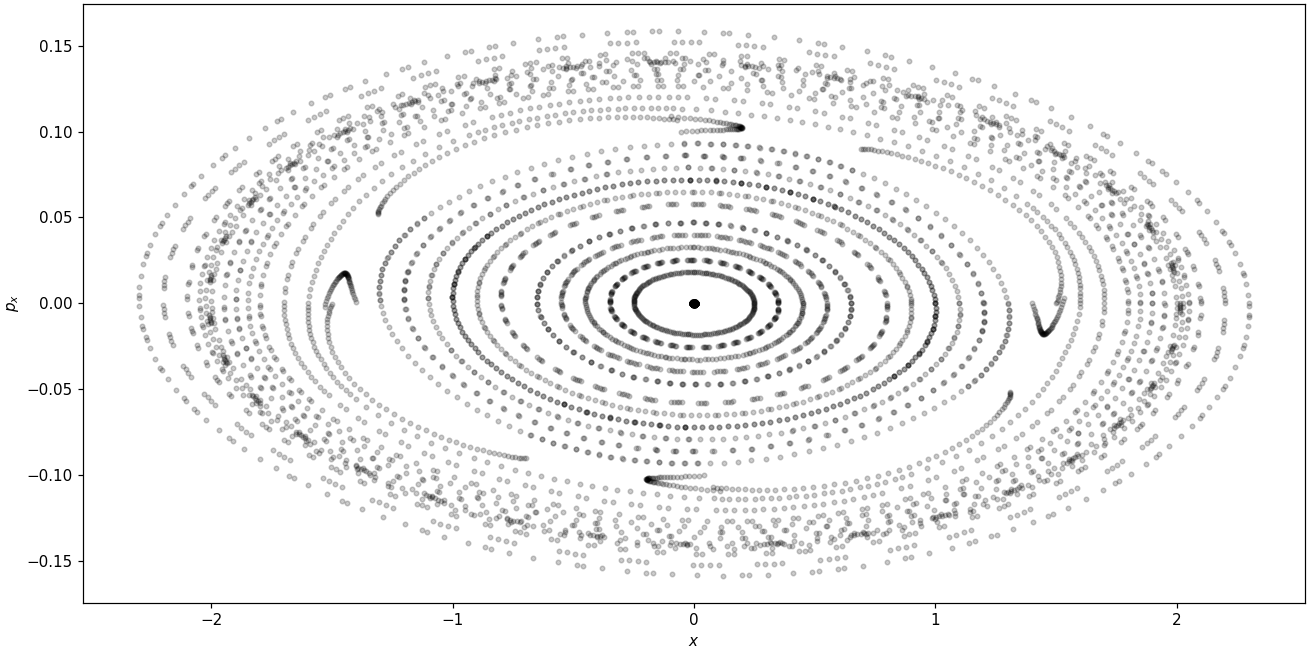

In [177]:
X_ElByEl_2_4_2_array = np.array(X_ElByEl_2_4_2)
X_ElByEl_2_4_2_symplectic_array = np.array(X_ElByEl_2_4_2_symplectic)

New_FIG(X_ElByEl_2_4_2_array[:,:,0],X_ElByEl_2_4_2_array[:,:,1],X_ElByEl_2_4_2_array[:,:,2],X_ElByEl_2_4_2_array[:,:,3])
New_FIG(X_ElByEl_2_4_2_symplectic_array[:,:,0],X_ElByEl_2_4_2_symplectic_array[:,:,1],X_ElByEl_2_4_2_symplectic_array[:,:,2],X_ElByEl_2_4_2_symplectic_array[:,:,3])

# Dragt-Finn

## Non-Symplectic Taylor

In [295]:
DF = dragt_finn_factorization(
    [
        truncatexpx(x5,5).subs(inv_track_rep), 
        truncatexpx(px5,5).subs(inv_track_rep),
        y,
        py,
        z,
        delta]
    ,
    [x,px,y,py,z,delta]
)

2021-03-21 23:30:26,909 - root -INFO - Starting dragt-finn factorization.
2021-03-21 23:30:26,916 - root -INFO - Taylor in
2021-03-21 23:30:26,918 - root -INFO - [23.9073272701143*p_x**5 - 12.2294313060645*p_x**4*x + 2.35057576305856*p_x**3*x**2 + 31.391998236128*p_x**3 - 0.19435065532495*p_x**2*x**3 - 4.21693222942753*p_x**2*x + 0.00603583551537842*p_x*x**4 + 0.425788979047864*p_x*x**2 + 13.961720303762*p_x - 6.65549177984779e-5*x**5 - 0.0214520420923887*x**3 + 0.0895672776045307*x, -4.13295381458583*p_x**5 + 2.05479586767351*p_x**4*x - 0.389489623821952*p_x**3*x**2 - 4.54523461941834*p_x**3 + 0.0316481609290919*p_x**2*x**3 + 0.365947343431892*p_x**2*x - 0.000943760342169951*p_x*x**4 - 0.016286042898348*p_x*x**2 + 0.0895672776045306*p_x + 9.49379443045722e-6*x**5 + 0.000556567143567553*x**3 - 0.0710474966455395*x, y, p_y, z, delta]
2021-03-21 23:30:26,939 - root -INFO - Transforming Taylor to Lie.
2021-03-21 23:30:26,940 - root -INFO - [23.9073272701143*p_x**5 - 12.2294313060645*p_x**

100%|██████████| 3/3 [00:00<00:00, 724.03it/s]


2021-03-21 23:30:27,133 - root -INFO - Taylor out
2021-03-21 23:30:27,134 - root -INFO - [59.8464000054147*p_x**5 - 29.7848078666777*p_x**4*x + 5.64866302635963*p_x**3*x**2 + 66.2731392868885*p_x**3 - 0.459285123051812*p_x**2*x**3 - 5.48713152209848*p_x**2*x + 0.013717576097059*p_x*x**4 + 0.265526545541856*p_x*x**2 - 1.33226762955019e-14*p_x - 0.000138515336802577*x**5 - 0.00969235008541798*x**3 - 1.11022302462516e-16*x, 1.32842140822718*p_x**5 - 0.684850214976431*p_x**4*x + 0.132121282589017*p_x**3*x**2 + 1.82327772065713*p_x**3 - 0.0109738437581831*p_x**2*x**3 - 0.266834223582844*p_x**2*x + 0.000344312123752871*p_x*x**4 + 0.0287934782022258*p_x*x**2 - 3.87835273852364e-6*x**5 - 0.00147431149126382*x**3, 0, 0, 0, 0]
2021-03-21 23:30:27,144 - root -INFO - Taylor in
2021-03-21 23:30:27,145 - root -INFO - [59.8464000054147*p_x**5 - 29.7848078666777*p_x**4*x + 5.64866302635963*p_x**3*x**2 + 66.2731392868885*p_x**3 - 0.459285123051812*p_x**2*x**3 - 5.48713152209848*p_x**2*x + 0.01371757609

100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


2021-03-21 23:30:34,621 - root -INFO - Taylor out
2021-03-21 23:30:34,622 - root -INFO - [59.8464000054146*p_x**5 - 26.004271054948*p_x**4*x + 4.20729531734061*p_x**3*x**2 - 0.294793220349416*p_x**2*x**3 + 0.00820141127631657*p_x*x**4 - 1.33226762955019e-14*p_x - 8.36933934060569e-5*x**5 - 1.0*x, 5.10895821995694*p_x**5 - 2.12621792399546*p_x**4*x + 0.296613185291414*p_x**3*x**2 - 0.00576612004236821*p_x**3 - 0.0164900085789255*p_x**2*x**3 - 0.00130767804098819*p_x**2*x + 0.000399134067149391*p_x*x**4 - 0.000283572054028122*p_x*x**2 - p_x - 3.87835273852364e-6*x**5, -y, -p_y, -z, -delta]
2021-03-21 23:30:34,635 - root -INFO - Taylor in
2021-03-21 23:30:34,636 - root -INFO - [59.8464000054146*p_x**5 - 26.004271054948*p_x**4*x + 4.20729531734061*p_x**3*x**2 - 0.294793220349416*p_x**2*x**3 + 0.00820141127631657*p_x*x**4 - 1.33226762955019e-14*p_x - 8.36933934060569e-5*x**5 - 1.0*x, 5.10895821995694*p_x**5 - 2.12621792399546*p_x**4*x + 0.296613185291414*p_x**3*x**2 - 0.00576612004236821*p_

100%|██████████| 3/3 [00:00<00:00, 2017.14it/s]


2021-03-21 23:30:34,683 - root -INFO - Taylor out
2021-03-21 23:30:34,685 - root -INFO - [59.8464000054146*p_x**5 - 26.004271054948*p_x**4*x + 4.20729531734061*p_x**3*x**2 - 0.294793220349416*p_x**2*x**3 + 0.00820141127631657*p_x*x**4 - 1.33226762955019e-14*p_x - 8.36933934060569e-5*x**5 - 2.0*x, 5.10895821995694*p_x**5 - 2.12621792399546*p_x**4*x + 0.296613185291414*p_x**3*x**2 - 0.00576612004236821*p_x**3 - 0.0164900085789255*p_x**2*x**3 - 0.00130767804098819*p_x**2*x + 0.000399134067149391*p_x*x**4 - 0.000283572054028122*p_x*x**2 - 2*p_x - 3.87835273852364e-6*x**5, -2*y, -2*p_y, -2*z, -2*delta]
2021-03-21 23:30:34,697 - root -INFO - Taylor in
2021-03-21 23:30:34,698 - root -INFO - [59.8464000054146*p_x**5 - 26.004271054948*p_x**4*x + 4.20729531734061*p_x**3*x**2 - 0.294793220349416*p_x**2*x**3 + 0.00820141127631657*p_x*x**4 - 1.33226762955019e-14*p_x - 8.36933934060569e-5*x**5 - 2.0*x, 5.10895821995694*p_x**5 - 2.12621792399546*p_x**4*x + 0.296613185291414*p_x**3*x**2 - 0.0057661200

100%|██████████| 3/3 [00:25<00:00,  8.39s/it]


2021-03-21 23:31:24,406 - root -INFO - Taylor out
2021-03-21 23:31:24,407 - root -INFO - [7.105427357601e-15*p_x**5 - 1.33226762955019e-14*p_x - 3.0*x, -0.0918959910326533*p_x**5 - 0.022570265325156*p_x**4*x + 0.00181996494199815*p_x**3*x**2 - 0.00576612004236821*p_x**3 - 8.71860262923949e-5*p_x**2*x**3 - 0.00130767804098819*p_x**2*x - 1.93328998808936e-5*p_x*x**4 - 0.000283572054028122*p_x*x**2 - 3*p_x, -3*y, -3*p_y, -3*z, -3*delta]
Implemented only to 5th order so far.


In [296]:
df0inv = Matrix(np.linalg.inv(DF[0][:2,:2])) * Matrix([[x0],[px0]])
conv_rep = [(x,df0inv[0]),(px,df0inv[1])]
conv_rep

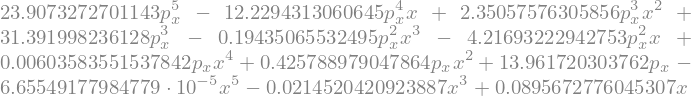

In [297]:
truncatexpx(x5,5).subs(inv_track_rep)

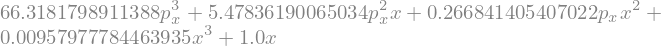

In [244]:
xl4 = truncatexpx(x5,3).subs(inv_track_rep).subs(conv_rep).expand().subs(inv_track_rep)
xl4

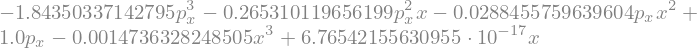

In [245]:
pxl4 = truncatexpx(px5,3).subs(inv_track_rep).subs(conv_rep).expand().subs(inv_track_rep)
pxl4

In [241]:
h40, h31, h22, h13, h04 = symbols("h_{40} h_{31} h_{22} h_{13} h_{04}")
L4 = h40 * x**4 + h31 * x**3 * px + h22 * x**2 * px**2 + h13 *x *px**3 + h04 * px**4
L4

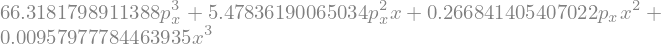

In [249]:
diff(L4,px).subs([(h04,xl4.coeff(px**3)/4.),(h13,xl4.coeff(px**2*x)/3),(h22,xl4.coeff(px*x**2)/2),(h31,xl4.coeff(x**3))])

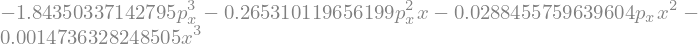

In [256]:
-diff(L4,x).subs([(h13,-pxl4.coeff(px**3)),(h22,-pxl4.coeff(px**2*x)/2),(h31,-pxl4.coeff(px*x**2)/3),(h40,-pxl4.coeff(x**3)/4)])

In [250]:
[(h04,xl4.coeff(px**3)/4.),(h13,xl4.coeff(px**2*x)/3),(h22,xl4.coeff(px*x**2)/2),(h31,xl4.coeff(x**3))]

In [257]:
[(h13,-pxl4.coeff(px**3)),(h22,-pxl4.coeff(px**2*x)/2),(h31,-pxl4.coeff(px*x**2)/3),(h40,-pxl4.coeff(x**3)/4)]

In [260]:
NL4 = L4.subs([(h04,xl4.coeff(px**3)/4.),(h13,xl4.coeff(px**2*x)/3),(h22,xl4.coeff(px*x**2)/2),(h31,xl4.coeff(x**3)),(h40,-pxl4.coeff(x**3)/4)])

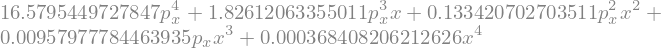

In [294]:
NL4

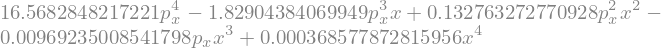

In [293]:
DF[2]

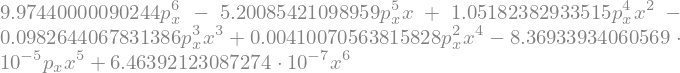

In [299]:
DF[4]

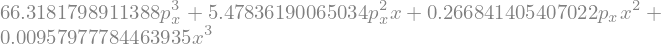

In [261]:
diff(NL4,px)

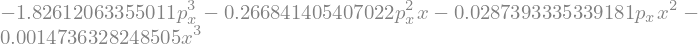

In [262]:
-diff(NL4,x)

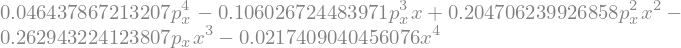

In [197]:
L4.subs([(h04,xl4.coeff(px**3)/4.),(h13,xl4.coeff(px**2*x)/3.),(h22,xl4.coeff(px*x**2)/2),(h31,xl4.coeff(x**3)),(h40,-pxl4.coeff(x**3)/4)]).subs(px,1/np.sqrt(13.)*px).subs(x,x/np.sqrt(0.08))

In [189]:
diff(L4,px)

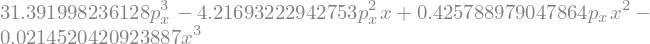

In [190]:
xl4

In [187]:
-diff(L4,x)

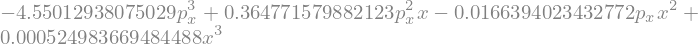

In [46]:
pxl4

In [51]:
LieOperator(L4,[x],[px]).LieMap(-x,1).ham+x

In [52]:
LieOperator(L4,[x],[px]).LieMap(-px,1).ham+px

In [59]:
NL4 = L4.subs([(h04,xl4.coeff(px**3)/4.),(h13,xl4.coeff(px**2*x)/3.),(h22,xl4.coeff(px*x**2)/2),(h31,xl4.coeff(x**3)),(h40,-pxl4.coeff(x**3)/4)])

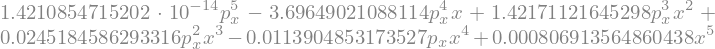

In [70]:
0.5 * ( diff(NL4,px) * diff(diff(NL4,px),x) - diff(NL4,x) * diff(diff(NL4,px),px) ).expand()

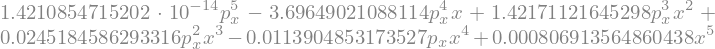

In [192]:
# higher order terms like in eq 55 Willeke
(LieOperator(NL4,[x],[px]).LieMap(x,2).ham - LieOperator(NL4,[x],[px]).LieMap(x,1).ham)

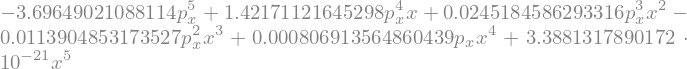

In [74]:
-0.5 * ( diff(NL4,px) * diff(diff(NL4,x),x) - diff(NL4,x) * diff(diff(NL4,x),px) ).expand()

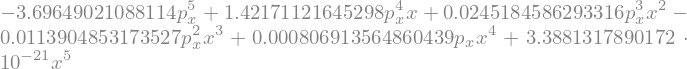

In [73]:
# higher order terms like in eq 55 Willeke
LieOperator(NL4,[x],[px]).LieMap(px,2).ham - LieOperator(NL4,[x],[px]).LieMap(px,1).ham

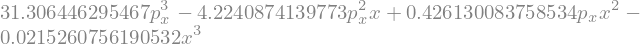

In [191]:
diff(diff(NL4,px),px)-

In [76]:
diff(diff(NL4,x),px)

In [78]:
h30, h21, h12, h03 = symbols("h_{30} h_{21} h_{12} h_{03}")
L3 = h30 * x**3 + h21 * x**2 * px + h12 *x *px**2 + h03 * px**3
L3

In [83]:
(diff(L3,px) * diff(diff(L3,x),px)).expand() - (diff(L3,x) * diff(diff(L3,px),px)).expand()

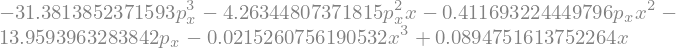

In [332]:
coord = [x,px]
lie_f2 = DF[0][:2,:2]
lie_f3 = LieOperator(DF[1].subs(inv_track_rep),[x], [px])
lie_f4 = LieOperator(-DF[2].subs(inv_track_rep),[x], [px])

vec = np.dot(lie_f2,coord)
truncate((lie_f4.LieMap((lie_f3.LieMap(vec[0],1)).expand(),1)).expand(),4)

## Symplectic Taylor

In [809]:
DFS = dragt_finn_factorization(
    [
        xx5_expr, 
        px5_expr,
        y,
        py,
        z,
        delta]
    ,
    [x,px,y,py,z,delta]
)

2021-03-23 16:28:04,267 - root -INFO - Starting dragt-finn factorization.
2021-03-23 16:28:04,289 - root -INFO - Taylor in
2021-03-23 16:28:04,292 - root -INFO - [-4.2565*p_x**3 - 8.513*p_x + x, 0.0244997272999999*p_x**3 + 1.0489994546*p_x + 0.00122679999999997*x, y, p_y, z, delta]
2021-03-23 16:28:04,308 - root -INFO - Transforming Taylor to Lie.
2021-03-23 16:28:04,311 - root -INFO - [-4.2565*p_x**3 - 8.513*p_x + x, 0.0244997272999999*p_x**3 + 1.0489994546*p_x + 0.00122679999999997*x, y, p_y, z, delta]
2021-03-23 16:28:04,319 - root -INFO - coords are [x, p_x, y, p_y, z, delta]
2021-03-23 16:28:04,322 - root -INFO - Extracting linear transfer matrix from linear part of [-4.2565*p_x**3 - 8.513*p_x + x, 0.0244997272999999*p_x**3 + 1.0489994546*p_x + 0.00122679999999997*x, y, p_y, z, delta]
2021-03-23 16:28:04,336 - root -INFO - [[ 1.00000000e+00 -8.51300000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.22680000e-03  1.04899945e+00  0.00000000e+00  0.000000

100%|██████████| 3/3 [00:00<00:00, 960.67it/s]


2021-03-23 16:28:04,425 - root -INFO - Taylor out
2021-03-23 16:28:04,427 - root -INFO - [-4.01767644357618*p_x**3, 0.0280539828995437*p_x**3, 0, 0, 0, 0]
2021-03-23 16:28:04,430 - root -INFO - Taylor in
2021-03-23 16:28:04,431 - root -INFO - [-4.01767644357618*p_x**3, 0.0280539828995437*p_x**3, 0, 0, 0, 0]
2021-03-23 16:28:04,432 - root -INFO - Transforming Taylor to Lie.
2021-03-23 16:28:04,434 - root -INFO - [-4.01767644357618*p_x**3, 0.0280539828995437*p_x**3, 0, 0, 0, 0]
2021-03-23 16:28:04,436 - root -INFO - coords are [x, p_x, y, p_y, z, delta]
2021-03-23 16:28:04,454 - root -INFO - Cleaning up Taylor vector map.
2021-03-23 16:28:04,455 - root -WARNING - coords used - [x, y, z], phases used - [p_x, p_y, delta]


100%|██████████| 3/3 [00:00<00:00, 42.00it/s]


2021-03-23 16:28:04,773 - root -INFO - Taylor out
2021-03-23 16:28:04,774 - root -INFO - [0.0841619486986312*p_x**2*x - x, -p_x, -y, -p_y, -z, -delta]


In [810]:
xx5_expr, px5_expr

OSError: [Errno 12] Cannot allocate memory

⎛           3                                      3                          
⎝- 4.2565⋅pₓ  - 8.513⋅pₓ + x, 0.0244997272999999⋅pₓ  + 1.0489994546⋅pₓ + 0.001

                ⎞
22679999999997⋅x⎠

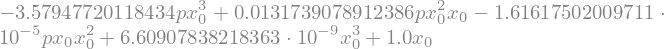

In [226]:
xx5_expr.subs([(x,(Matrix(np.linalg.inv(DFS[0][:2,:2])) * Matrix([[x0],[px0]]))[0]),(px,(Matrix(np.linalg.inv(DFS[0][:2,:2])) * Matrix([[x0],[px0]]))[1])]).expand()

In [231]:
diff(L4,px)

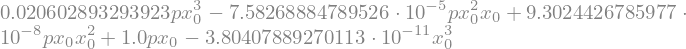

In [223]:
px5_expr.subs([(x,(Matrix(DFS[0][:2,:2]).inv() * Matrix([[x0],[px0]]))[0]),(px,(Matrix(DFS[0][:2,:2]).inv() * Matrix([[x0],[px0]]))[1])]).expand()

In [230]:
-diff(L4,x)

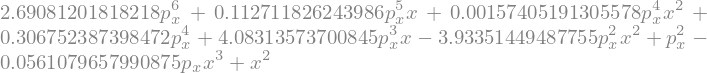

In [819]:
LieOperator(DFS[2],[x],[px]).BCH(LieOperator(x**2+px**2,[x],[px]),3).ham.doit().expand()

In [813]:
print(DFS[2])

-1.00441911089405*p_x**4 - 0.0280539828995437*p_x**3*x


In [1198]:
coord = [x,px]
lie_f2 = DFS[0]
lie_f3 = LieOperator(-DFS[1].subs(inv_track_rep),[x], [px])
lie_f4 = LieOperator(-DFS[2].subs(inv_track_rep),[x], [px])
# lie_f5 = LieOperator(-DFS[3].subs(inv_track_rep),[x], [px])
# lie_f6 = LieOperator(-DFS[4].subs(inv_track_rep),[x], [px])

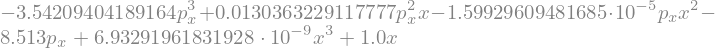

In [1200]:
vec = np.dot(lie_f2[:2,:2],coord)
truncate(lie_f4.LieMap(lie_f3.LieMap(vec[0],2).expand(),2),4)

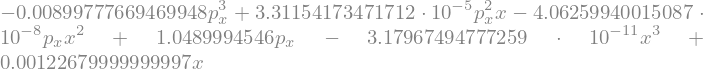

In [1201]:
vec = np.dot(lie_f2[:2,:2],coord)
truncate(lie_f4.LieMap(lie_f3.LieMap(vec[1],1).expand(),1),4)

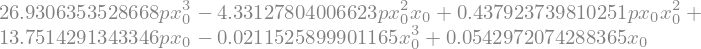

In [1202]:
truncatexpx(x5,4)

In [1212]:
lrep = [(x,(Matrix(DFS[0][:2,:2]).inv() * Matrix([[x0],[px0]]))[0]),(px,(Matrix(DFS[0][:2,:2]).inv() * Matrix([[x0],[px0]]))[1])]
lrep

100%|██████████| 800/800 [00:00<00:00, 4439.27it/s]


<IPython.core.display.Javascript object>


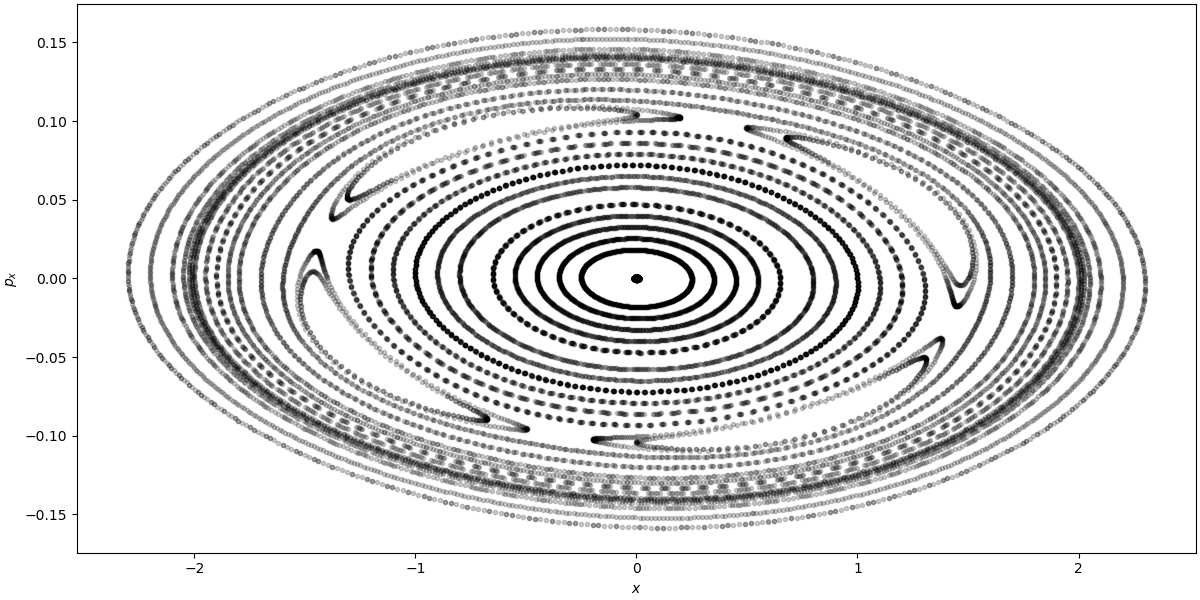

In [40]:
X_ElByEl_2_4_2 = np.array([r0])
duration = 800

for i in tqdm(range(1, duration + 1)): 
#     r_2 = track(X_ElByEl_2_4_2[-1],ffxt2,ffpxt2)
    r_2 = track_symplectic(X_ElByEl_2_4_2[-1])
    
    X_ElByEl_2_4_2 = np.append(X_ElByEl_2_4_2, [r_2], axis = 0)
    
X_ElByEl_2_4_2_array = np.array(X_ElByEl_2_4_2)
New_FIG(X_ElByEl_2_4_2_array[:,:,0],X_ElByEl_2_4_2_array[:,:,1],X_ElByEl_2_4_2_array[:,:,2],X_ElByEl_2_4_2_array[:,:,3])

# Manual following Willeke

In [98]:
poly_x = x + x**2 + 2* x*px + px**2 +x**3 + x**2 *px + 2*x*px**2 + px**3
poly_p = px + x**2 - 2* x*px - px**2 +x**3 + 5*x**2 *px + 3*x*px**2 - Rational(2,3)* px**3
taylor_vector = [poly_x,poly_p]

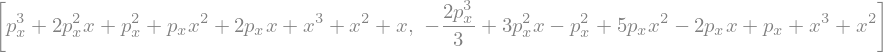

In [100]:
taylor_vector

In [117]:
DFS[1]

In [130]:
LieOperator(DFS[1],[x],[px]).LieMap(x,1).ham

In [128]:
diff(DFS[1],px)

In [132]:
LieOperator(DFS[1],[x],[px]).LieMap(px,1).ham

In [133]:
-diff(DFS[1],x)

In [134]:
LieOperator(DFS[1],[x],[px]).LieMap(x,2).ham-LieOperator(DFS[1],[x],[px]).LieMap(x,1).ham

In [137]:
DFS[2]

In [135]:
DFS = dragt_finn_factorization(
    [
        poly_x, 
        poly_p,
        y,
        py,
        z,
        delta]
    ,
    [x,px,y,py,z,delta]
)

2021-03-21 17:22:43,271 - root -INFO - Starting dragt-finn factorization.
2021-03-21 17:22:43,275 - root -INFO - Taylor in
2021-03-21 17:22:43,277 - root -INFO - [p_x**3 + 2*p_x**2*x + p_x**2 + p_x*x**2 + 2*p_x*x + x**3 + x**2 + x, -2*p_x**3/3 + 3*p_x**2*x - p_x**2 + 5*p_x*x**2 - 2*p_x*x + p_x + x**3 + x**2, y, p_y, z, delta]
2021-03-21 17:22:43,286 - root -INFO - Transforming Taylor to Lie.
2021-03-21 17:22:43,288 - root -INFO - [p_x**3 + 2*p_x**2*x + p_x**2 + p_x*x**2 + 2*p_x*x + x**3 + x**2 + x, -2*p_x**3/3 + 3*p_x**2*x - p_x**2 + 5*p_x*x**2 - 2*p_x*x + p_x + x**3 + x**2, y, p_y, z, delta]
2021-03-21 17:22:43,298 - root -INFO - coords are [x, p_x, y, p_y, z, delta]
2021-03-21 17:22:43,304 - root -INFO - Extracting linear transfer matrix from linear part of [p_x**3 + 2*p_x**2*x + p_x**2 + p_x*x**2 + 2*p_x*x + x**3 + x**2 + x, -2*p_x**3/3 + 3*p_x**2*x - p_x**2 + 5*p_x*x**2 - 2*p_x*x + p_x + x**3 + x**2, y, p_y, z, delta]
2021-03-21 17:22:43,312 - root -INFO - [[1. 0. 0. 0. 0. 0.]
 [0.

100%|██████████| 3/3 [00:00<00:00, 42.43it/s]


2021-03-21 17:22:43,559 - root -INFO - Taylor out
2021-03-21 17:22:43,560 - root -INFO - [1.0*p_x**3 + 2.0*p_x**2*x + 2.0*p_x**2 - 1.0*p_x*x**2 + 4.0*p_x*x - 1.0*x**3 + 2.0*x**2, -0.666666666666667*p_x**3 + 1.0*p_x**2*x - 2.0*p_x**2 + 3.0*p_x*x**2 - 4.0*p_x*x + 1.0*x**3 + 2.0*x**2, 0, 0, 0, 0]
2021-03-21 17:22:43,569 - root -INFO - Taylor in
2021-03-21 17:22:43,571 - root -INFO - [1.0*p_x**3 + 2.0*p_x**2*x + 2.0*p_x**2 - 1.0*p_x*x**2 + 4.0*p_x*x - 1.0*x**3 + 2.0*x**2, -0.666666666666667*p_x**3 + 1.0*p_x**2*x - 2.0*p_x**2 + 3.0*p_x*x**2 - 4.0*p_x*x + 1.0*x**3 + 2.0*x**2, 0, 0, 0, 0]
2021-03-21 17:22:43,579 - root -INFO - Transforming Taylor to Lie.
2021-03-21 17:22:43,580 - root -INFO - [1.0*p_x**3 + 2.0*p_x**2*x + 2.0*p_x**2 - 1.0*p_x*x**2 + 4.0*p_x*x - 1.0*x**3 + 2.0*x**2, -0.666666666666667*p_x**3 + 1.0*p_x**2*x - 2.0*p_x**2 + 3.0*p_x*x**2 - 4.0*p_x*x + 1.0*x**3 + 2.0*x**2, 0, 0, 0, 0]
2021-03-21 17:22:43,588 - root -INFO - coords are [x, p_x, y, p_y, z, delta]
2021-03-21 17:22:43,61

100%|██████████| 3/3 [00:00<00:00,  8.85it/s]


2021-03-21 17:22:44,348 - root -INFO - Taylor out
2021-03-21 17:22:44,350 - root -INFO - [2.0*p_x**3 + 4.0*p_x**2*x + 2.0*p_x**2 - 2.0*p_x*x**2 + 4.0*p_x*x - 2.0*x**3 + 2.0*x**2 - x, -1.33333333333333*p_x**3 + 2.0*p_x**2*x - 2.0*p_x**2 + 6.0*p_x*x**2 - 4.0*p_x*x - p_x + 2.0*x**3 + 2.0*x**2, -y, -p_y, -z, -delta]


In [138]:
DFS = dragt_finn_factorization(
    [
        xx5_expr, 
        px5_expr,
        y,
        py,
        z,
        delta]
    ,
    [x,px,y,py,z,delta]
)

2021-03-21 17:23:29,735 - root -INFO - Starting dragt-finn factorization.
2021-03-21 17:23:29,741 - root -INFO - Taylor in
2021-03-21 17:23:29,743 - root -INFO - [-4.2565*p_x**3 - 8.513*p_x + x, 0.0244997272999999*p_x**3 + 1.0489994546*p_x + 0.00122679999999997*x, y, p_y, z, delta]
2021-03-21 17:23:29,757 - root -INFO - Transforming Taylor to Lie.
2021-03-21 17:23:29,759 - root -INFO - [-4.2565*p_x**3 - 8.513*p_x + x, 0.0244997272999999*p_x**3 + 1.0489994546*p_x + 0.00122679999999997*x, y, p_y, z, delta]
2021-03-21 17:23:29,765 - root -INFO - coords are [x, p_x, y, p_y, z, delta]
2021-03-21 17:23:29,768 - root -INFO - Extracting linear transfer matrix from linear part of [-4.2565*p_x**3 - 8.513*p_x + x, 0.0244997272999999*p_x**3 + 1.0489994546*p_x + 0.00122679999999997*x, y, p_y, z, delta]
2021-03-21 17:23:29,777 - root -INFO - [[ 1.00000000e+00 -8.51300000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.22680000e-03  1.04899945e+00  0.00000000e+00  0.000000

100%|██████████| 3/3 [00:00<00:00, 2048.00it/s]


2021-03-21 17:23:29,839 - root -INFO - Taylor out
2021-03-21 17:23:29,840 - root -INFO - [-4.01767644357618*p_x**3, 0.0280539828995437*p_x**3, 0, 0, 0, 0]
2021-03-21 17:23:29,843 - root -INFO - Taylor in
2021-03-21 17:23:29,844 - root -INFO - [-4.01767644357618*p_x**3, 0.0280539828995437*p_x**3, 0, 0, 0, 0]
2021-03-21 17:23:29,846 - root -INFO - Transforming Taylor to Lie.
2021-03-21 17:23:29,846 - root -INFO - [-4.01767644357618*p_x**3, 0.0280539828995437*p_x**3, 0, 0, 0, 0]
2021-03-21 17:23:29,848 - root -INFO - coords are [x, p_x, y, p_y, z, delta]
2021-03-21 17:23:29,859 - root -INFO - Cleaning up Taylor vector map.
2021-03-21 17:23:29,860 - root -WARNING - coords used - [x, y, z], phases used - [p_x, p_y, delta]


100%|██████████| 3/3 [00:00<00:00, 93.02it/s]


2021-03-21 17:23:29,965 - root -INFO - Taylor out
2021-03-21 17:23:29,966 - root -INFO - [-8.03535288715237*p_x**3 - 0.0841619486986312*p_x**2*x - x, 0.0561079657990875*p_x**3 - p_x, -y, -p_y, -z, -delta]


In [61]:
xx5_expr, px5_expr

In [139]:
conv = Matrix(DFS[0][:2,:2]).inv() * Matrix([[x0],[px0]])

conv_rep = [(x,conv[0]),(px,conv[1])]
conv_rep

In [140]:
# subtract linear part
xx5_expr

In [141]:
h40, h31, h22, h13, h04 = symbols("h_{40} h_{31} h_{22} h_{13} h_{04}")
L4 = h40 * x**4 + h31 * x**3 * px + h22 * x**2 * px**2 + h13 *x *px**3 + h04 * px**4
L4

In [142]:
diff(L4,px),-diff(L4,x)

In [143]:
LieOperator(-DFS[2],[x],[px]).LieMap(x,1).ham

In [150]:
(Matrix(DFS[0][:2,:2]) * Matrix([[x0],[px0]]))[0]

In [154]:
LieOperator(DFS[2],[x],[px]).LieMap(px,1).ham

In [151]:
LieOperator(DFS[2],[x],[px]).LieMap( (Matrix(DFS[0][:2,:2]) * Matrix([[x0],[px0]]))[0],1).ham

In [146]:
LieOperator(DFS[2],[x],[px]).LieMap( (Matrix(DFS[0][:2,:2]) * Matrix([[x0],[px0]]))[1],2).ham

## Taylor up to order 3

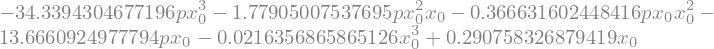

In [58]:
truncatexpx(x5,3)

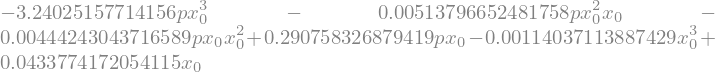

In [59]:
truncatexpx(px5,3)

## Eliminate Linear part

In [60]:
conv = Matrix(DF[0][:2,:2]).inv() * Matrix([[x0],[px0]])

conv_rep = [(x,conv[0]),(px,conv[1])]

NameError: name 'DF' is not defined

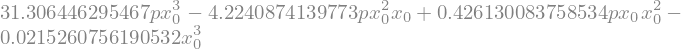

In [414]:
# subtract linear part
truncatexpx(x5,3)-truncatexpx(x5,1).subs(conv_rep)

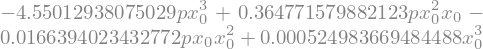

In [415]:
# subtract linear part
truncatexpx(px5,3)-truncatexpx(px5,1).subs(conv_rep)

## Extract L_3

In [416]:
h30, h21, h12, h03 = symbols("h_{30} h_{21} h_{12} h_{03}")
L3 = h30 * x**3 + h21 * x**2 * px + h12 *x *px**2 + h03 * px**3
L3

In [425]:
diff(L3,px),-diff(L3,x)

In [420]:
LieOperator(L3,[x],[px]).LieMap(x,1).ham

In [424]:
LieOperator(L3,[x],[px]).LieMap(px,1).ham

In [426]:
# notice to opposite signs

Willeke uses (eq 31):
$$
:H:x = \frac{\partial H}{\partial p} \frac{\partial x}{\partial x} -  \frac{\partial H}{\partial x} \frac{\partial p}{\partial x} 
$$

In [428]:
L_3 = Function("L_3")(x,px)

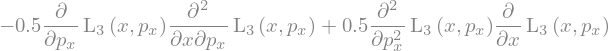

In [433]:
-(LieOperator(L_3,[x],[px]).LieMap(x,2).ham - LieOperator(L_3,[x],[px]).LieMap(x,1).ham) # like this it is like eq 55 in Willeke

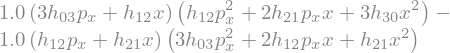

In [435]:
-(LieOperator(L_3,[x],[px]).LieMap(x,2).ham - LieOperator(L_3,[x],[px]).LieMap(x,1).ham).subs(L_3,L3).doit()

## Extracting L_4

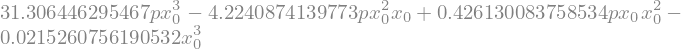

In [439]:
xl4 = truncatexpx(x5,3)-truncatexpx(x5,1).subs(conv_rep)
xl4

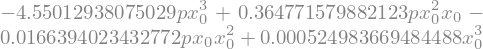

In [440]:
pxl4 = truncatexpx(px5,3)-truncatexpx(px5,1).subs(conv_rep)
pxl4

In [437]:
h40, h31, h22, h13, h04 = symbols("h_{40} h_{31} h_{22} h_{13} h_{04}")
L4 = h40 * x**4 + h31 * x**3 * px + h22 * x**2 * px**2 + h13 *x *px**3 + h04 * px**4
L4

In [438]:
diff(L4,px),-diff(L4,x)

In [441]:
diff(L4,px)

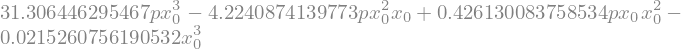

In [442]:
xl4

In [443]:
-diff(L4,x)

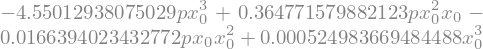

In [444]:
pxl4

In [399]:
h30, h21, h12, h03 = symbols("h_{30} h_{21} h_{12} h_{03}")
L3 = h30 * x**3 + h21 * x**2 * px + h12 *x *px**2 + h03 * px**3
diff(L3,px)

In [364]:
DF = dragt_finn_factorization(
    [
        x2.subs(inv_track_rep), 
        px2.subs(inv_track_rep),
        y,
        py,
        z,
        delta]
    ,
    [x,px,y,py,z,delta]
)

2021-03-21 14:31:28,285 - root -INFO - Starting dragt-finn factorization.
2021-03-21 14:31:28,292 - root -INFO - Taylor in
2021-03-21 14:31:28,295 - root -INFO - [-0.00245010339*p_x**5 + 0.00092382373371645*p_x**4*x + 0.16446639096*p_x**3 - 0.0413419166956152*p_x**2*x + 0.0048022026444*p_x*x**2 + 0.33873319548*p_x - 0.000201188279787138*x**3 + 0.971480682775365*x, 0.00010264708152405*p_x**5 - 0.0140543644492692*p_x**3 + 0.0024011013222*p_x**2*x - 0.000201188279787138*p_x*x**2 + 0.971480682775365*p_x - 0.1659792657852*x, y, p_y, z, delta]
2021-03-21 14:31:28,308 - root -INFO - Transforming Taylor to Lie.
2021-03-21 14:31:28,309 - root -INFO - [-0.00245010339*p_x**5 + 0.00092382373371645*p_x**4*x + 0.16446639096*p_x**3 - 0.0413419166956152*p_x**2*x + 0.0048022026444*p_x*x**2 + 0.33873319548*p_x - 0.000201188279787138*x**3 + 0.971480682775365*x, 0.00010264708152405*p_x**5 - 0.0140543644492692*p_x**3 + 0.0024011013222*p_x**2*x - 0.000201188279787138*p_x*x**2 + 0.971480682775365*p_x - 0.165

100%|██████████| 3/3 [00:00<00:00, 961.56it/s]


2021-03-21 14:31:28,506 - root -INFO - Taylor out
2021-03-21 14:31:28,507 - root -INFO - [-0.00241500435725627*p_x**5 + 0.000897479241371597*p_x**4*x + 0.164537028687322*p_x**3 - 0.0409763125531181*p_x**2*x + 0.0047334085402223*p_x*x**2 + 5.55111512312578e-17*p_x - 0.000195451034787592*x**3 - 1.11022302462516e-16*x, -0.000306947501734686*p_x**5 + 0.000153335983083835*p_x**4*x + 0.0136445026666535*p_x**3 - 0.00452928918502115*p_x**2*x + 0.000601617103399984*p_x*x**2 - 1.11022302462516e-16*p_x - 3.33931696493685e-5*x**3, 0, 0, 0, 0]
2021-03-21 14:31:28,519 - root -INFO - Taylor in
2021-03-21 14:31:28,522 - root -INFO - [-0.00241500435725627*p_x**5 + 0.000897479241371597*p_x**4*x + 0.164537028687322*p_x**3 - 0.0409763125531181*p_x**2*x + 0.0047334085402223*p_x*x**2 + 5.55111512312578e-17*p_x - 0.000195451034787592*x**3 - 1.11022302462516e-16*x, -0.000306947501734686*p_x**5 + 0.000153335983083835*p_x**4*x + 0.0136445026666535*p_x**3 - 0.00452928918502115*p_x**2*x + 0.000601617103399984*p_x

100%|██████████| 3/3 [00:05<00:00,  2.00s/it]


2021-03-21 14:31:42,461 - root -INFO - Taylor out
2021-03-21 14:31:42,462 - root -INFO - [-0.00241500435725627*p_x**5 + 0.00100704669801548*p_x**4*x - 3.1824254958189e-5*p_x**3*x**2 + 5.04790385480017e-6*p_x**2*x**3 - 4.43179359432948e-7*p_x*x**4 + 5.55111512312578e-17*p_x + 2.17300967023956e-8*x**5 - 1.0*x, -0.000197380045090806*p_x**5 + 0.000121511728125646*p_x**4*x + 5.04790385480017e-6*p_x**3*x**2 - 1.42681843858846e-5*p_x**3 - 4.43179359432949e-7*p_x**2*x**3 + 0.00020411935520115*p_x**2*x + 2.17300967023956e-8*p_x*x**4 + 1.52639990372076e-5*p_x*x**2 - 1.0*p_x, -y, -p_y, -z, -delta]
2021-03-21 14:31:42,481 - root -INFO - Taylor in
2021-03-21 14:31:42,482 - root -INFO - [-0.00241500435725627*p_x**5 + 0.00100704669801548*p_x**4*x - 3.1824254958189e-5*p_x**3*x**2 + 5.04790385480017e-6*p_x**2*x**3 - 4.43179359432948e-7*p_x*x**4 + 5.55111512312578e-17*p_x + 2.17300967023956e-8*x**5 - 1.0*x, -0.000197380045090806*p_x**5 + 0.000121511728125646*p_x**4*x + 5.04790385480017e-6*p_x**3*x**2 - 

100%|██████████| 3/3 [00:00<00:00, 425.75it/s]


2021-03-21 14:31:42,569 - root -INFO - Taylor out
2021-03-21 14:31:42,576 - root -INFO - [-0.00241500435725627*p_x**5 + 0.00100704669801548*p_x**4*x - 3.1824254958189e-5*p_x**3*x**2 + 5.04790385480017e-6*p_x**2*x**3 - 4.43179359432948e-7*p_x*x**4 + 5.55111512312578e-17*p_x + 2.17300967023956e-8*x**5 - 2.0*x, -0.000197380045090806*p_x**5 + 0.000121511728125646*p_x**4*x + 5.04790385480017e-6*p_x**3*x**2 - 1.42681843858846e-5*p_x**3 - 4.43179359432949e-7*p_x**2*x**3 + 0.00020411935520115*p_x**2*x + 2.17300967023956e-8*p_x*x**4 + 1.52639990372076e-5*p_x*x**2 - 2.0*p_x, -2*y, -2*p_y, -2*z, -2*delta]
2021-03-21 14:31:42,593 - root -INFO - Taylor in
2021-03-21 14:31:42,596 - root -INFO - [-0.00241500435725627*p_x**5 + 0.00100704669801548*p_x**4*x - 3.1824254958189e-5*p_x**3*x**2 + 5.04790385480017e-6*p_x**2*x**3 - 4.43179359432948e-7*p_x*x**4 + 5.55111512312578e-17*p_x + 2.17300967023956e-8*x**5 - 2.0*x, -0.000197380045090806*p_x**5 + 0.000121511728125646*p_x**4*x + 5.04790385480017e-6*p_x**3

100%|██████████| 3/3 [00:34<00:00, 11.48s/it]


2021-03-21 14:32:52,110 - root -INFO - Taylor out
2021-03-21 14:32:52,111 - root -INFO - [5.55111512312578e-17*p_x - 3.0*x, 4.0292945122897e-6*p_x**5 + 0.000105599600646551*p_x**4*x + 1.00958077096003e-5*p_x**3*x**2 - 1.42681843858846e-5*p_x**3 - 1.32953807829885e-6*p_x**2*x**3 + 0.00020411935520115*p_x**2*x + 1.30380580214374e-7*p_x*x**4 + 1.52639990372076e-5*p_x*x**2 - 3.0*p_x, -3*y, -3*p_y, -3*z, -3*delta]
Implemented only to 5th order so far.


In [377]:
coord = [x,px]
lie_f2 = DF[0]
lie_f3 = LieOperator(-DF[1].subs(inv_track_rep),[x], [px])
lie_f4 = LieOperator(-DF[2].subs(inv_track_rep),[x], [px])

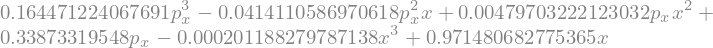

In [368]:
vec = np.dot(lie_f2[:2,:2],coord)
truncate(lie_f4.LieMap(lie_f3.LieMap(vec[0],2).expand(),2),4)

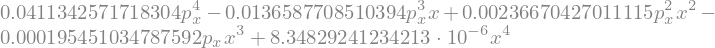

In [378]:
DF[2]

In [1175]:
tic = time.perf_counter()
# QF
x1  = taylor_qf2_x.subs(track_rep).subs(rept).expand()
px1 = taylor_qf2_px.subs(track_rep).subs(rept).expand()

# QF - D
x2  = taylor_d4_x.subs(list(zip([x,px],[x1,px1]))).subs(rept).expand()
px2 = taylor_d4_px.subs(list(zip([x,px],[x1,px1]))).subs(rept).expand()

# QF - D - QD 
x3  = taylor_qd2_x.subs(list(zip([x,px],[x2,px2]))).subs(rept).expand()
px3 = taylor_qd2_px.subs(list(zip([x,px],[x2,px2]))).subs(rept).expand()

# QF - D - QD - D
x4  = taylor_d4_x.subs(list(zip([x,px],[x3,px3]))).subs(rept).expand()
px4 = taylor_d4_px.subs(list(zip([x,px],[x3,px3]))).subs(rept).expand()

# QF - D - QD - D - QF
x5  = taylor_qf2_x.subs(list(zip([x,px],[x4,px4]))).subs(rept).expand()
px5 = taylor_qf2_px.subs(list(zip([x,px],[x4,px4]))).subs(rept).expand()


In [1219]:
lrept = [(x,(Matrix(DF[0][:2,:2]).inv() * Matrix([[x0],[px0]]))[0]),(px,(Matrix(DF[0][:2,:2]).inv() * Matrix([[x0],[px0]]))[1])]
lrept

In [262]:
-DF[0]

array([[ -0.08947516, -13.95939633,  -0.        ,  -0.        ,
         -0.        ,  -0.        ],
       [  0.07107381,  -0.08947516,  -0.        ,  -0.        ,
         -0.        ,  -0.        ],
       [ -0.        ,  -0.        ,  -1.        ,  -0.        ,
         -0.        ,  -0.        ],
       [ -0.        ,  -0.        ,  -0.        ,  -1.        ,
         -0.        ,  -0.        ],
       [ -0.        ,  -0.        ,  -0.        ,  -0.        ,
         -1.        ,  -0.        ],
       [ -0.        ,  -0.        ,  -0.        ,  -0.        ,
         -0.        ,  -1.        ]])

In [66]:
(LD+LD+LQF+LQF+LQD).subs(rept)

In [272]:
DF[0]

array([[ 0.08956728, 13.9617203 ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.0710475 ,  0.08956728,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ]])

In [267]:
np.sin( np.arccos(DF[0][0,0])) / (DF[0][1,0] / np.sin( np.arccos(DF[0][0,0]) ) )

In [268]:
((DF[0][1,0]) / np.sin( np.arccos(DF[0][0,0]) ) )**2

In [273]:
-np.arccos(DF[0][0,0]) / ((DF[0][1,0]) / np.sin( np.arccos(DF[0][0,0]) ) )

In [339]:
H1 = -0.5*20.76295461161268*(0.005092253857836318*x**2+px**2)
H1

In [280]:
H1 = -0.5*(0.005092253857836318*x**2+px**2)
H1

In [260]:
diff(H1,x)

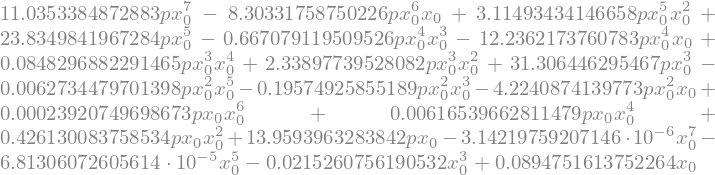

In [298]:
x5

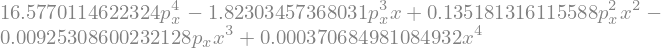

In [297]:
DF[2]

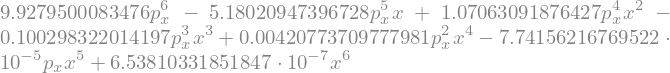

In [296]:
DF[4]

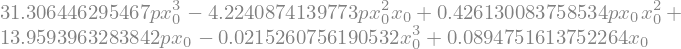

In [155]:
truncatexpx(x5,4)

In [213]:
np.linalg.inv(DF[0])[0,:]

array([  0.08946145, -13.95725714,   0.        ,   0.        ,
         0.        ,   0.        ])

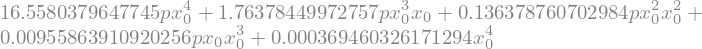

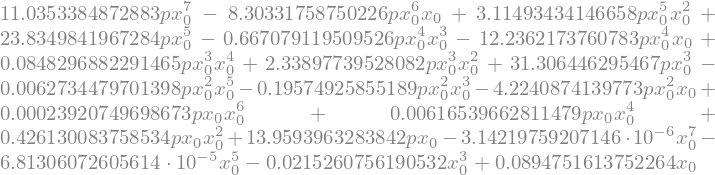

In [196]:
x5

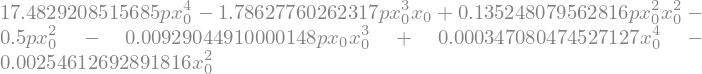

In [234]:
truncatexpx(lie_f4.BCH(lie_f3.BCH(LieOperator(H1,[x],[px]),4),4).ham.doit().expand().subs(x,x0).subs(px,px0),4)

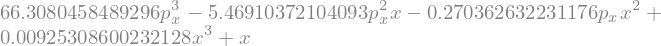

In [339]:
LieOperator(-16.5770114622324*px**4+1.82303457368031*px**3*x+0.135181316115588*px**2*x**2-0.00925308600232128*px*x**3-0.000370684981084932*x**4,[x],[px]).LieMap(x,1).ham

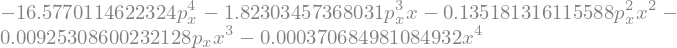

In [340]:
DF[2]

In [133]:
L = (LD+LD+LQF+LQF+LQD).subs(rept)

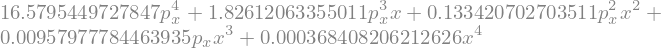

In [326]:
NL4

In [401]:
H1

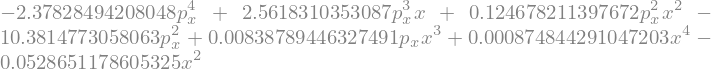

In [403]:
LieOperator(NL4,[x],[px]).BCH(LieOperator(H1,[x],[px]),2).doit().ham.expand()

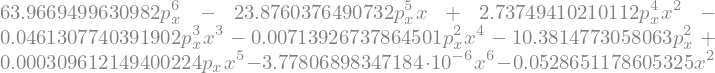

In [405]:
LieOperator(DF[4],[x],[px]).BCH(LieOperator(H1,[x],[px]),2).doit().ham.expand()

In [328]:
iv = Matrix(DF[0][:2,:2])*Matrix([[x0],[px0]])
invconvrep = [(x,iv[0]),(px,iv[1])]

In [330]:
invconvrep

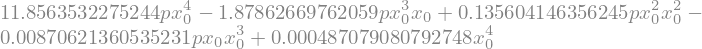

In [334]:
NL4.subs(conv_rep).expand()

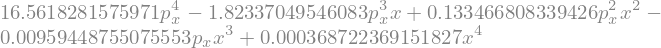

In [329]:
NL4.subs(invconvrep).expand().subs(inv_track_rep)

In [340]:
H1

In [421]:
vec = np.dot(DF[0][:2,:2],[x0,px0])
vec

array([13.961720303762*px_0 + 0.0895672776045307*x_0,
       0.0895672776045306*px_0 - 0.0710474966455395*x_0], dtype=object)

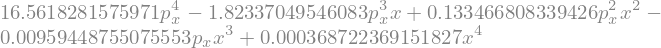

In [423]:
NL4.subs(x,vec[0]).subs(px,vec[1]).subs(inv_track_rep).expand()

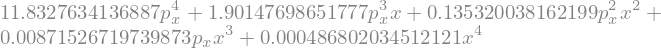

In [427]:
DF[2].subs(x,vec[0]).subs(px,vec[1]).subs(inv_track_rep).expand()

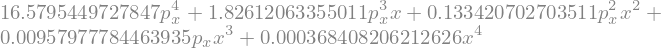

In [428]:
NL4

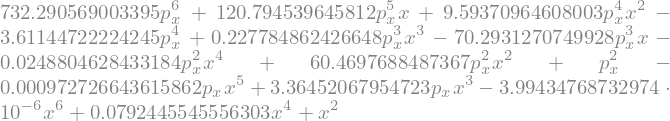

In [520]:
LieOperator(NL4,[x],[px]).BCH(LieOperator(x**2+px**2,[x],[px]),3).ham.doit().expand()

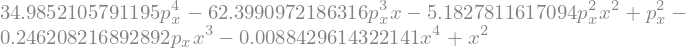

In [441]:
LieOperator(NL4,[x],[px]).BCH(LieOperator(x**2,[x],[px]),2).ham.doit().expand()+LieOperator(NL4,[x],[px]).BCH(LieOperator(px**2,[x],[px]),2).ham.doit().expand()

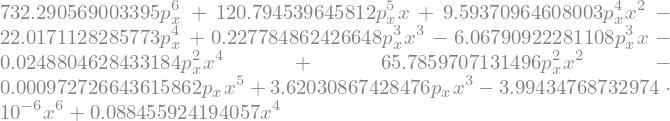

In [448]:
LieOperator(NL4,[x],[px]).BCH(LieOperator(x**2+px**2,[x],[px]),3).ham.doit().expand()-LieOperator(NL4,[x],[px]).BCH(LieOperator(x**2+px**2,[x],[px]),2).ham.doit().expand()

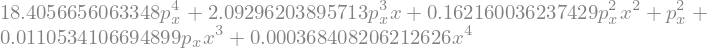

In [437]:
LieOperator(NL4,[x],[px]).BCH(LieOperator(px**2,[x],[px]),2).ham.doit().expand()

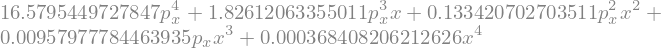

In [528]:
NL4

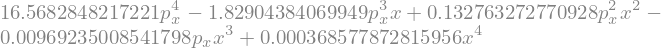

In [529]:
DF[2]

In [548]:
print(DF[4])

9.97440000090244*p_x**6 - 5.20085421098959*p_x**5*x + 1.05182382933515*p_x**4*x**2 - 0.0982644067831386*p_x**3*x**3 + 0.00410070563815828*p_x**2*x**4 - 8.36933934060569e-5*p_x*x**5 + 6.46392123087274e-7*x**6


In [550]:
f6 = 9.97440000090244*px**6 + 5.20085421098959*px**5*x + 1.05182382933515*px**4*x**2 + 0.0982644067831386*px**3*x**3 + 0.00410070563815828*px**2*x**4 + 8.36933934060569e-5*px*x**5 + 6.46392123087274e-7*x**6

In [532]:
DF[0][:2,:2]

array([[ 0.08956728, 13.9617203 ],
       [-0.0710475 ,  0.08956728]])

In [530]:
Matrix(DF[0][:2,:2]).det()

In [610]:
nop = Matrix([[ 0.7265285 ,  8.02588056, 24.84396298]]) * Matrix([[x**2],[x*px],[px**2]])
nop[0]

In [636]:
nop = Matrix([[ 1.1 ,  0, 7.5]]) * Matrix([[x**2],[x*px],[px**2]])
nop[0]

<IPython.core.display.Javascript object>


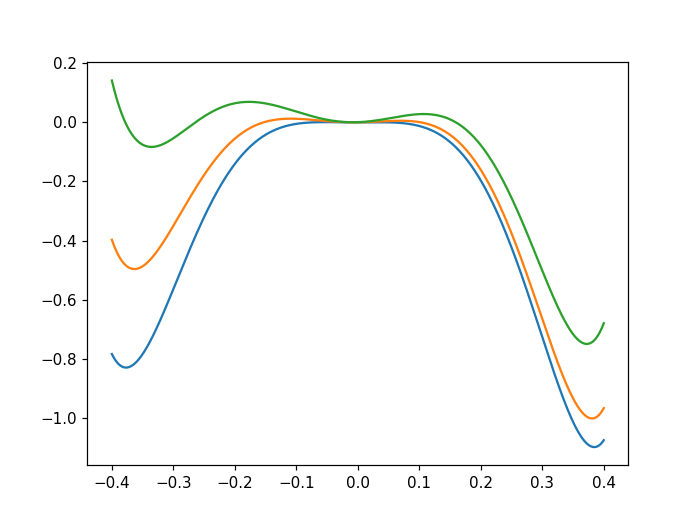

In [671]:
nop = Matrix([[ .9 ,  0, 7.5]]) * Matrix([[x**2],[x*px],[px**2]])

func3 = lambdify((x,px), 
                 LieOperator(NL4,[x],[px]).BCH(LieOperator(nop[0],[x],[px]),3).ham.doit().expand()
                 -LieOperator(NL4,[x],[px]).BCH(LieOperator(nop[0],[x],[px]),2).ham.doit().expand())
plt.figure()
plt.plot(P,func3(0.1,P))
plt.plot(P,func3(0.2,P))
plt.plot(P,func3(0.3,P))
# plt.ylim(0,.2)

In [762]:
nop = Matrix([[  0.001,0.01,.1]]) * Matrix([[x**2],[x*px],[px**2]])
solve(diff((LieOperator(NL4,[x],[px]).BCH(LieOperator(nop[0],[x],[px]),3).ham.doit().expand()
 -LieOperator(NL4,[x],[px]).BCH(LieOperator(nop[0],[x],[px]),2).ham.doit().expand()).subs(px,0),x))

In [791]:
nop = Matrix([[  0.004,0.07,7]]) * Matrix([[x**2],[x*px],[px**2]])
solve(diff((LieOperator(NL4,[x],[px]).BCH(LieOperator(nop[0],[x],[px]),3).ham.doit().expand()
 -LieOperator(NL4,[x],[px]).BCH(LieOperator(nop[0],[x],[px]),2).ham.doit().expand()).subs(px,0),x))

In [746]:
nop = Matrix([[  0.001,0.01,10]]) * Matrix([[x**2],[x*px],[px**2]])
(diff((LieOperator(NL4,[x],[px]).BCH(LieOperator(nop[0],[x],[px]),3).ham.doit().expand()
 -LieOperator(NL4,[x],[px]).BCH(LieOperator(nop[0],[x],[px]),2).ham.doit().expand()).subs(px,0),x)/x**3).simplify()

In [705]:
solve(diff((f6+NL4).subs(px,0),x))

In [798]:
DF[2]

OSError: [Errno 12] Cannot allocate memory

                   4                      3                         2  2      
16.5682848217221⋅pₓ  - 1.82904384069949⋅pₓ ⋅x + 0.132763272770928⋅pₓ ⋅x  - 0.0

                     3                         4
0969235008541798⋅pₓ⋅x  + 0.000368577872815956⋅x 

<IPython.core.display.Javascript object>


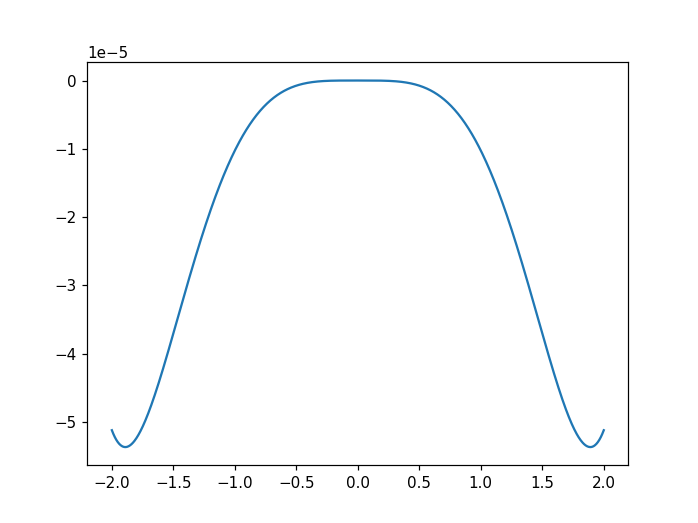

In [796]:
# nop = Matrix([[ .9 ,  0, 7.5]]) * Matrix([[x**2],[x*px],[px**2]])
np.linspace(-400,400,100)
func3 = lambdify((x,px), 
                 LieOperator(NL4,[x],[px]).BCH(LieOperator(nop[0],[x],[px]),3).ham.doit().expand()
                 -LieOperator(NL4,[x],[px]).BCH(LieOperator(nop[0],[x],[px]),2).ham.doit().expand())
plt.figure()
plt.plot(X,func3(X,0))


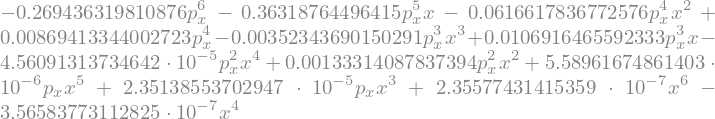

In [786]:
LieOperator(NL4,[x],[px]).BCH(LieOperator(nop[0],[x],[px]),3).ham.doit().expand()-LieOperator(NL4,[x],[px]).BCH(LieOperator(nop[0],[x],[px]),2).ham.doit().expand()

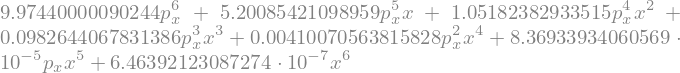

In [767]:
f6

In [824]:
print(DFS[2])

-1.00441911089405*p_x**4 - 0.0280539828995437*p_x**3*x


<IPython.core.display.Javascript object>


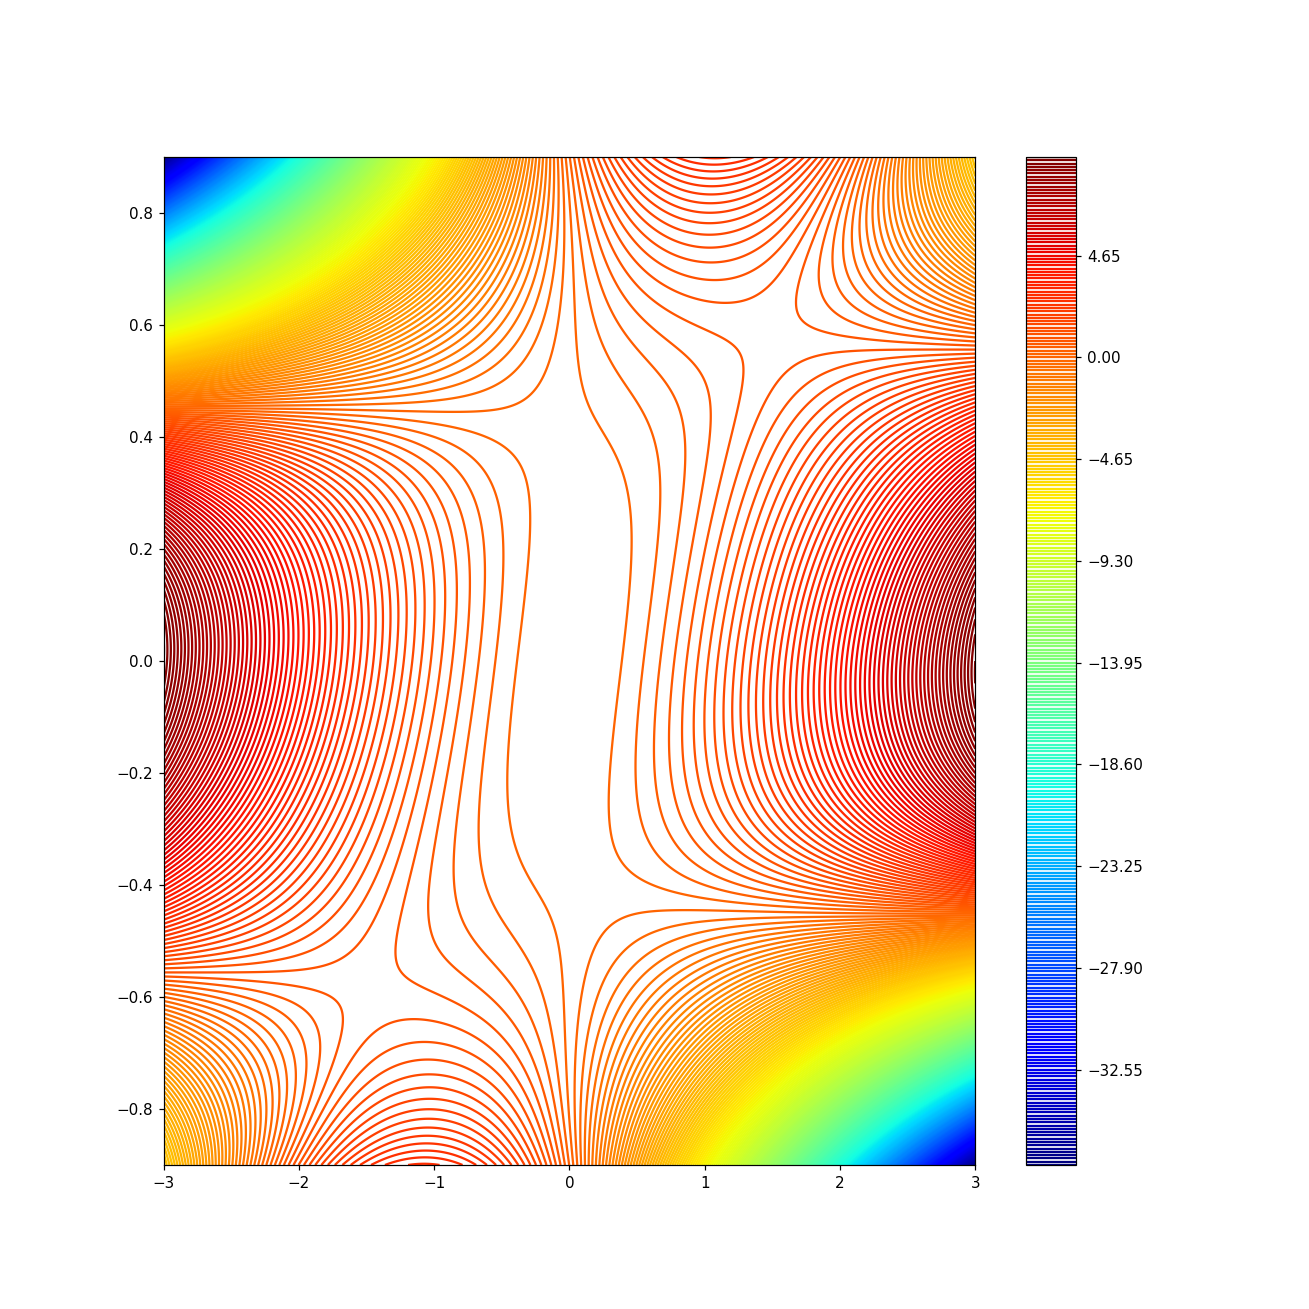

In [827]:
# func = lambdify((x,px),-L*DF[4]+H1)
# func2 = laambdify((x,px),LieOperator(H1,[x],[px]).BCH(LieOperator(-L*DF[2],[x],[px]),4).ham.doit().expand())
func3 = lambdify((x,px),DF[4]+DF[2]-0.005*H1)  
func3 = lambdify((x,px), LieOperator(NL4,[x],[px]).BCH(LieOperator(nop[0],[x],[px]),3).ham.doit().expand()-LieOperator(NL4,[x],[px]).BCH(LieOperator(nop[0],[x],[px]),2).ham.doit().expand())
func4 = lambdify((x,px), LieOperator(NL4,[x],[px]).BCH(LieOperator(nop[0],[x],[px]),3).ham.doit().expand())
func5 = lambdify((x,px), LieOperator(DFS[2].subs(px,-px),[x],[px]).BCH(LieOperator(x**2-x*px+px**2,[x],[px]),3).ham.doit().expand())
fig = plt.figure(figsize=(12,12))
gs = fig.add_gridspec(1, 1)
axes = [fig.add_subplot(gs[i, j]) for j in range(1) for i in range(1)]
# axes.append(fig.add_subplot(gs[1 - 1, 0]))#, projection="3d"))

xrange = 3
prange = .9
npoints= 1000

X = np.linspace(-xrange, xrange, npoints)
P = np.linspace(-prange, prange, npoints)
Xg, Pg = np.meshgrid(X, P)

Hlist = [func5(Xg,Pg),func3(Xg,Pg)]
cb = axes[0].contour(Xg, Pg, Hlist[0], levels=450,cmap=cm.jet)
# axes[1].contour(Xg, Pg, Hlist[1], levels=450,cmap=cm.jet)
# cset = axes[0].contour(Xg, Pg, Hlist[0], zdir='z', offset=0, cmap=cm.coolwarm)
# cset = axes[0].contour(Xg, Pg, Hlist[0], zdir='x', offset=-2.0, cmap=cm.coolwarm)
# cset = axes[0].contour(Xg, Pg, Hlist[0], zdir='y', offset=0.5, cmap=cm.coolwarm)
# axes[0].set_zlim(-.1,.1)
plt.colorbar(cb)

In [1033]:
DFS[0]

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])

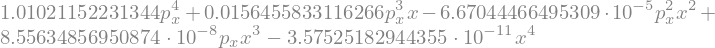

In [1031]:
lie_f4.ham.subs(lrep).expand().subs(inv_track_rep)

<IPython.core.display.Javascript object>


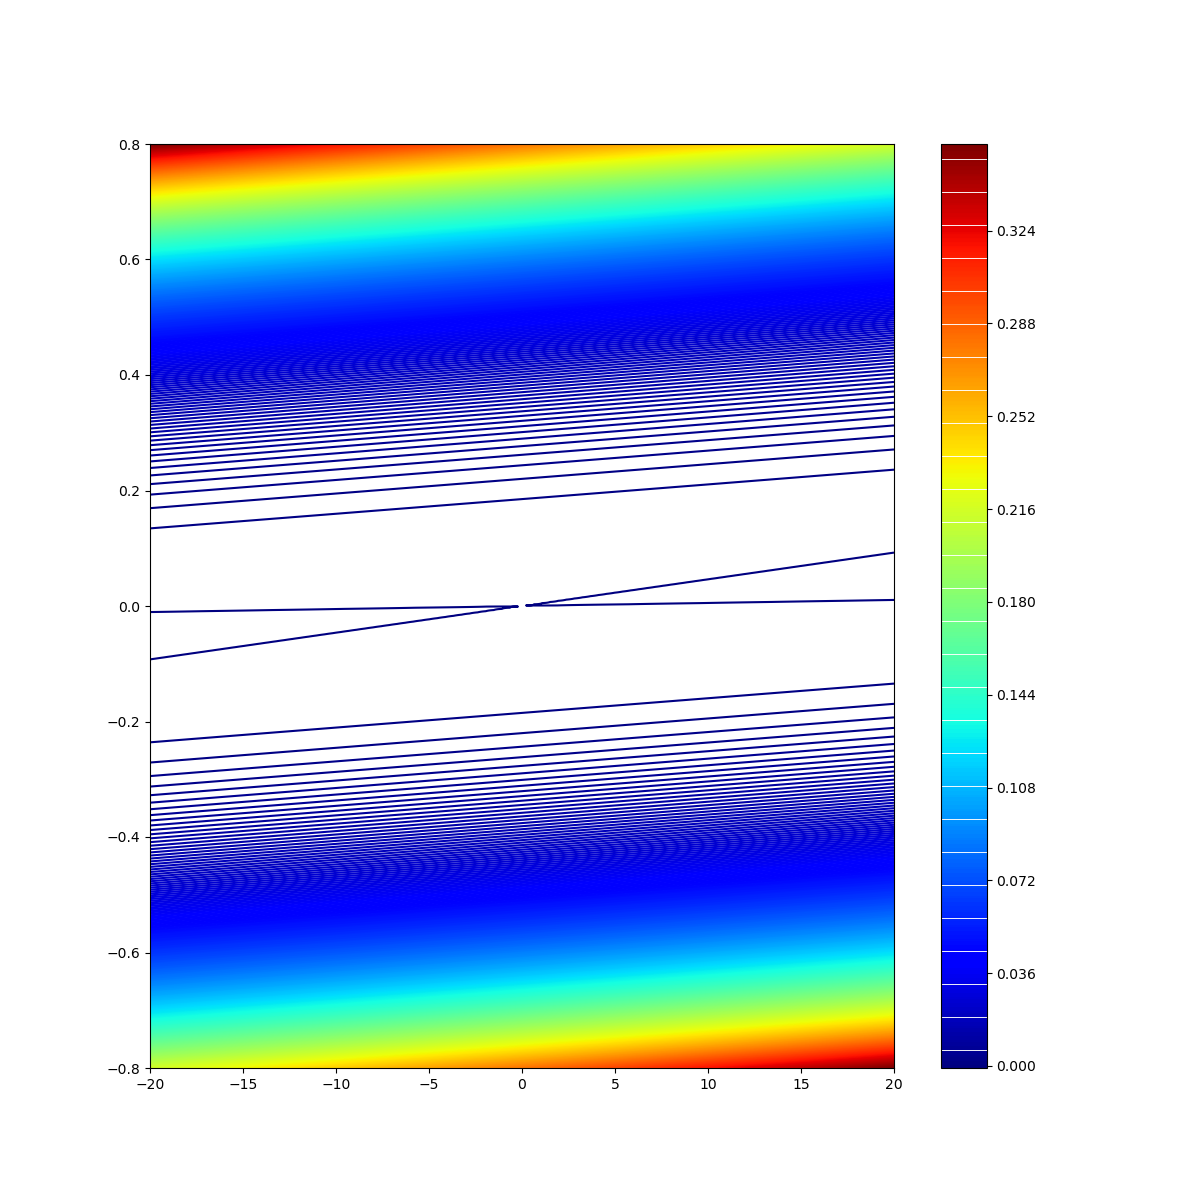

In [1178]:
lie_f4.ham.subs(lrep).expand().subs(inv_track_rep)
func = lambdify((x,px),lie_f4.ham.subs(lrep).expand().subs(inv_track_rep))
func2 = lambdify((x,px),DFS[2].subs(lrep).expand().subs(inv_track_rep))

fig = plt.figure(figsize=(12,12))
gs = fig.add_gridspec(1, 1)
axes = [fig.add_subplot(gs[i, j]) for j in range(1) for i in range(1)]
# axes.append(fig.add_subplot(gs[1 - 1, 0]))#, projection="3d"))

xrange = 20
prange = .8
npoints= 800

X = np.linspace(-xrange, xrange, npoints)
P = np.linspace(-prange, prange, npoints)
Xg, Pg = np.meshgrid(X, P)

Hlist = [func(Xg,Pg),func2(Xg,Pg)]

cb = axes[0].contour(Xg, Pg, Hlist[0], levels=450,cmap=cm.jet)
# axes[1].contour(Xg, Pg, Hlist[1], levels=450,cmap=cm.jet)
plt.colorbar(cb)

In [1181]:
lrep

<IPython.core.display.Javascript object>


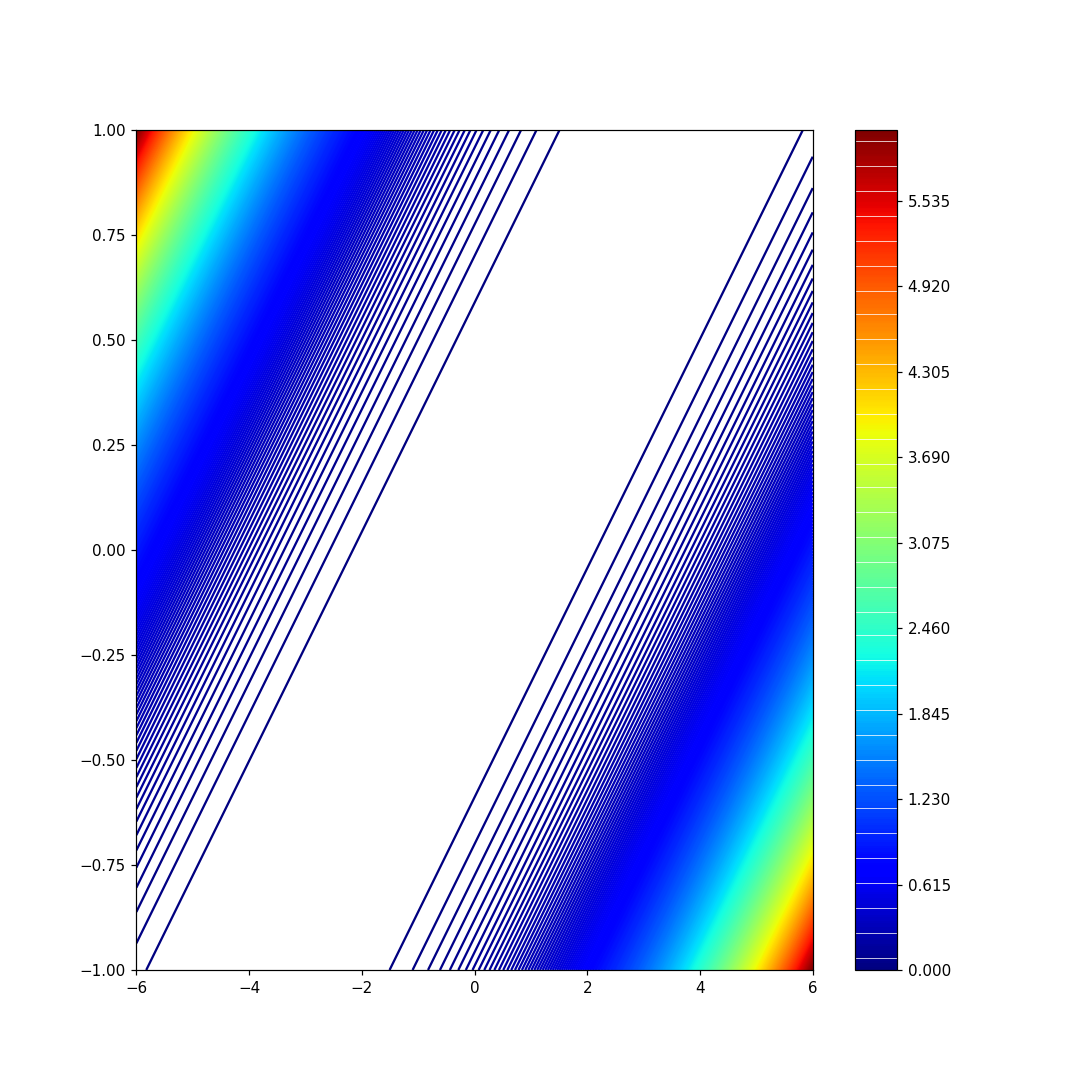

In [400]:
# func = lambdify((x,px),DFS[2].subs(lrept).expand().subs(inv_track_rep)+0.000001*x**2+0.01*px**2)
# func = lambdify((x,px),DFS[2]+0.0000001*x**2+0.01*px**2)
# func2 = lambdify((x,px),DFS[2].subs(lrep).expand().subs(inv_track_rep))
func = lambdify((x,px),0.9*x**2+4*px**2-0.893778954477837*px**4+0.975187902704094*px**3*x+0.399004463358615*px**2*x**2-0.0725578966034882*px*x**3-0.00494792243225243*x**4)
func = lambdify((x,px),0.124808545282611*(-px+0.272770996066309*x)**4)
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(1, 1)
axes = [fig.add_subplot(gs[i, j]) for j in range(1) for i in range(1)]
# axes.append(fig.add_subplot(gs[1 - 1, 0]))#, projection="3d"))

xrange = 6 #20
prange = 1 #5
npoints= 800

X = np.linspace(-xrange, xrange, npoints)
P = np.linspace(-prange, prange, npoints)
Xg, Pg = np.meshgrid(X, P)

Hlist = [func(Xg,Pg),func(Xg,Pg)]

cb = axes[0].contour(Xg, Pg, Hlist[0], levels=450,cmap=cm.jet)
# axes[1].contour(Xg, Pg, Hlist[1], levels=450,cmap=cm.jet)
plt.colorbar(cb)

<IPython.core.display.Javascript object>


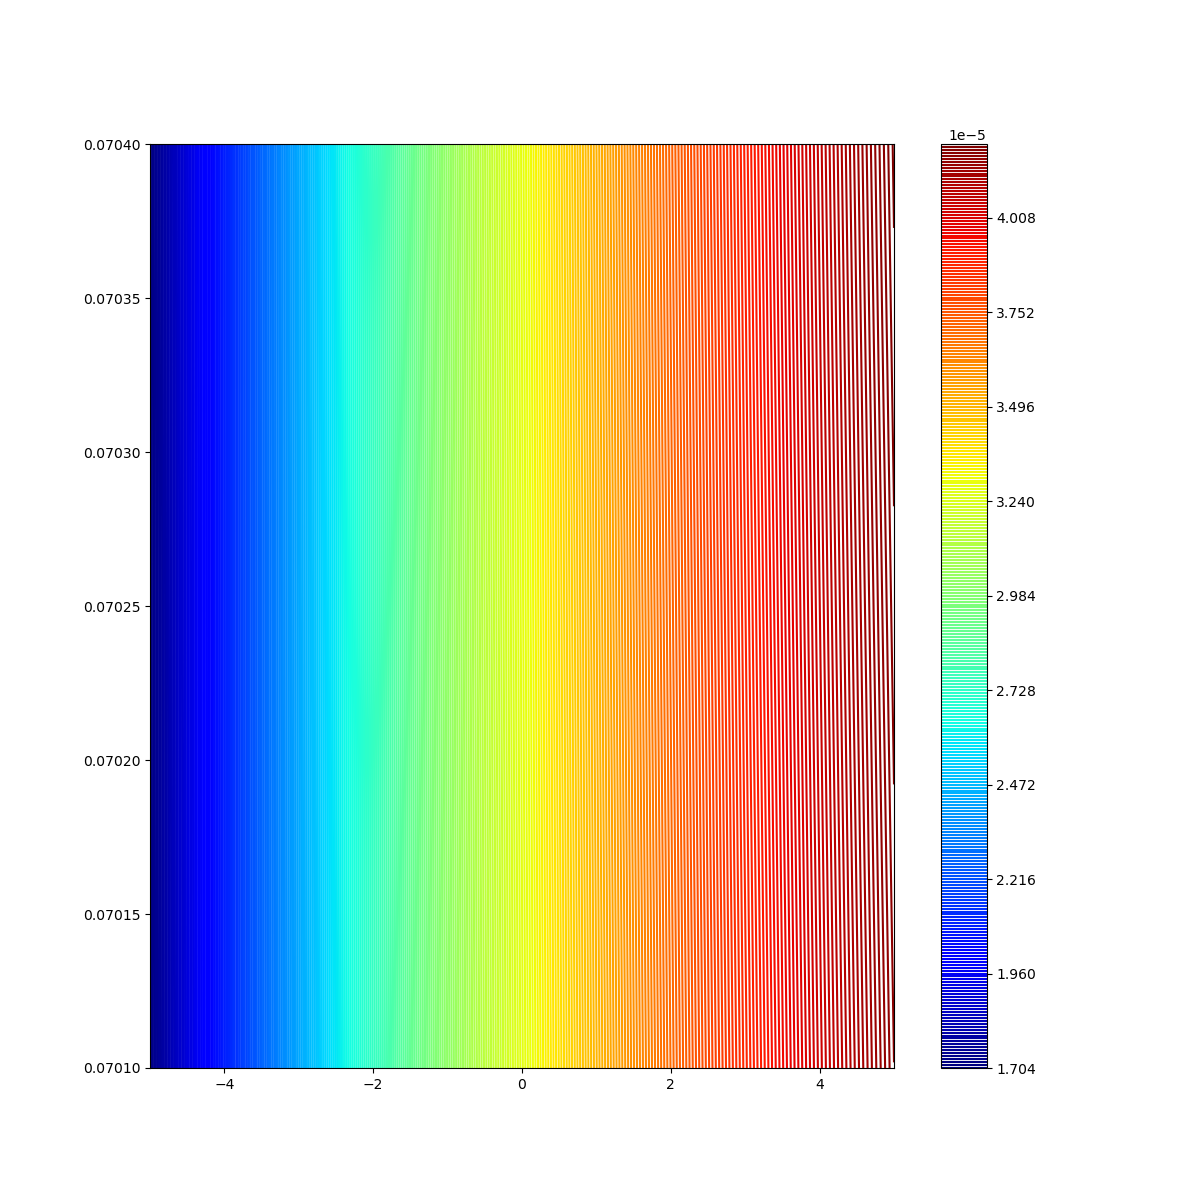

In [1184]:
func = lambdify((x,px),DFS[2].subs(lrep).expand().subs(inv_track_rep)+0.000000000025*x**2+0.01*px**2)
func2 = lambdify((x,px),DFS[2])

fig = plt.figure(figsize=(12,12))
gs = fig.add_gridspec(1, 1)
axes = [fig.add_subplot(gs[i, j]) for j in range(1) for i in range(1)]
# axes.append(fig.add_subplot(gs[1 - 1, 0]))#, projection="3d"))

xrange = 5
prange = .0704
npoints= 800

X = np.linspace(-xrange, xrange, npoints)
P = np.linspace(0.0701, prange, npoints)
Xg, Pg = np.meshgrid(X, P)

Hlist = [func(Xg,Pg),func2(Xg,Pg)]

cb = axes[0].contour(Xg, Pg, Hlist[0], levels=400,cmap=cm.jet)
# axes[1].contour(Xg, Pg, Hlist[1], levels=450,cmap=cm.jet)
plt.colorbar(cb)


In [1045]:
f2 = Function("f_2", commutative=False)(x,px)
f4 = Function("f_4", commutative=False)(x,px)

A , B = symbols("A B")

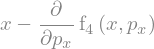

In [1046]:
LieOperator(f4,[x],[px]).LieMap(x,1).ham

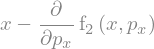

In [1059]:
LieOperator(f2,[x],[px]).LieMap(x,1).ham

In [1047]:
print_latex(LieOperator(f2,[x],[px]).LieMap(LieOperator(f4,[x],[px]).LieMap(px,1).ham,1).ham)

p_{x} + \frac{\partial}{\partial x} \operatorname{f_{2}}{\left(x,p_{x} \right)} + \frac{\partial}{\partial x} \operatorname{f_{4}}{\left(x,p_{x} \right)} - \frac{\partial^{2}}{\partial x^{2}} \operatorname{f_{4}}{\left(x,p_{x} \right)} \frac{\partial}{\partial p_{x}} \operatorname{f_{2}}{\left(x,p_{x} \right)} + \frac{\partial^{2}}{\partial x\partial p_{x}} \operatorname{f_{4}}{\left(x,p_{x} \right)} \frac{\partial}{\partial x} \operatorname{f_{2}}{\left(x,p_{x} \right)}


$$
x_1 = x - \frac{\partial}{\partial p_{x}} \operatorname{f_{2}}{\left(x,p_{x} \right)} - \frac{\partial}{\partial p_{x}} \operatorname{f_{4}}{\left(x,p_{x} \right)} - \frac{\partial^{2}}{\partial p_{x}^{2}} \operatorname{f_{4}}{\left(x,p_{x} \right)} \frac{\partial}{\partial x} \operatorname{f_{2}}{\left(x,p_{x} \right)} + \frac{\partial^{2}}{\partial x\partial p_{x}} \operatorname{f_{4}}{\left(x,p_{x} \right)} \frac{\partial}{\partial p_{x}} \operatorname{f_{2}}{\left(x,p_{x} \right)} \\
px_1 = p_{x} + \frac{\partial}{\partial x} \operatorname{f_{2}}{\left(x,p_{x} \right)} + \frac{\partial}{\partial x} \operatorname{f_{4}}{\left(x,p_{x} \right)} - \frac{\partial^{2}}{\partial x^{2}} \operatorname{f_{4}}{\left(x,p_{x} \right)} \frac{\partial}{\partial p_{x}} \operatorname{f_{2}}{\left(x,p_{x} \right)} + \frac{\partial^{2}}{\partial x\partial p_{x}} \operatorname{f_{4}}{\left(x,p_{x} \right)} \frac{\partial}{\partial x} \operatorname{f_{2}}{\left(x,p_{x} \right)}
$$

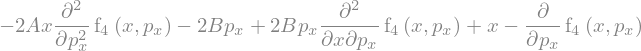

In [1056]:
LieOperator(f2,[x],[px]).LieMap(LieOperator(f4,[x],[px]).LieMap(x,1).ham,1).ham.subs(f2,A*x**2+B*px**2).doit()

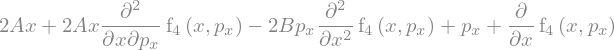

In [1057]:
LieOperator(f2,[x],[px]).LieMap(LieOperator(f4,[x],[px]).LieMap(px,1).ham,1).ham.subs(f2,A*x**2+B*px**2).doit()

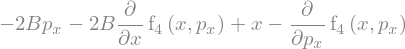

In [1058]:
LieOperator(f4,[x],[px]).LieMap(LieOperator(f2,[x],[px]).LieMap(x,1).ham,1).ham.subs(f2,A*x**2+B*px**2).doit()

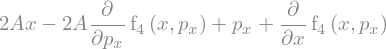

In [1060]:
LieOperator(f4,[x],[px]).LieMap(LieOperator(f2,[x],[px]).LieMap(px,1).ham,1).ham.subs(f2,A*x**2+B*px**2).doit()

In [1061]:
xx5_expr

In [1062]:
px5_expr

In [1064]:
AA = px5_expr.coeff(x)/2.
BB = xx5_expr.coeff(px)/2.
AA,BB

In [1070]:
DFS[0][:2,:2]

array([[ 1.00000000e+00, -8.51300000e+00],
       [ 1.22680000e-03,  1.04899945e+00]])

In [1073]:
LieOperator(AA*x**2+BB*px**2,[x],[px]).LieMap(x,1).ham

In [1074]:
LieOperator(AA*x**2+BB*px**2,[x],[px]).LieMap(px,1).ham

In [1075]:
2*AA*BB*2

# BCH

In [ ]:
MQFD = LieOperator(truncate(HQF2_op.BCH(HD_4_op,4).doit().expand(),5),[x],[px])
MQFDQD = LieOperator(truncate(MQFD.BCH(HQD2_op,4).doit().expand(),5),[x],[px])
MQFDQDD = LieOperator(truncate(MQFDQD.BCH(HD_4_op,4).doit().expand(),5),[x],[px])
MQFDQDDQF = LieOperator(truncate(MQFDQDD.BCH(HQF2_op,4).doit().expand(),5),[x],[px])
MQFDQDDQF.ham